# Unsupervised Learning Capstone

### Research Question:

Can Major League pitches be clustered using clustering techniques?

The objective of this project is to build a model that can cluster pitch types from Major League pitchers. Ultimately, making a universal pitch clustering model is the goal but for this project I will focus on one pitcher. 

The features include variables such as trajectory, spin rate, and velocity. The final model should be able to cluster pitch types via unsupervised learning and dimensionality reduction.

The data used in this project originates from pitchFX, a pitch tracking system created by Sportvision. The technology has been in every MLB stadium since 2006 and tracks every pitch that is thrown. Variables include velocity, spin rate, break angle, movement in horizontal space, runners on base, and even the outcome of the pitch. It is a baseball geek's dream.

The data was scraped and uploaded to Kaggle (https://www.kaggle.com/pschale/mlb-pitch-data-20152018#pitches.csv).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline
from sklearn import neighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings('ignore')

In [2]:
pitching = pd.read_csv(r'C:\Users\kylem\Desktop\Thinkful Data Science Projects\pitches.csv')
players = pd.read_csv(r'C:\Users\kylem\Desktop\Thinkful Data Science Projects\player_names.csv')

In [3]:
pitching.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2867154 entries, 0 to 2867153
Data columns (total 40 columns):
px                 float64
pz                 float64
start_speed        float64
end_speed          float64
spin_rate          float64
spin_dir           float64
break_angle        float64
break_length       float64
break_y            float64
ax                 float64
ay                 float64
az                 float64
sz_bot             float64
sz_top             float64
type_confidence    float64
vx0                float64
vy0                float64
vz0                float64
x                  float64
x0                 float64
y                  float64
y0                 float64
z0                 float64
pfx_x              float64
pfx_z              float64
nasty              float64
zone               float64
code               object
type               object
pitch_type         object
event_num          int64
b_score            float64
ab_id              float64
b

This dataset is massive... it contains over 2 million individual pitches thrown over the course of 4 total years in Major League Baseball. For the purposes of this project, we have many features that won't be needed so some cleaning will be necessary. 

In [4]:
pitching.head()

,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,ax,...,event_num,b_score,ab_id,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b
0,0.416,2.963,92.9,84.1,2305.052,159.235,-25.0,3.2,23.7,7.665,...,3,0.0,2.015000e+09,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.191,2.347,92.8,84.1,2689.935,151.402,-40.7,3.4,23.7,12.043,...,4,0.0,2.015000e+09,0.0,1.0,0.0,2.0,0.0,0.0,0.0
2,-0.518,3.284,94.1,85.2,2647.972,145.125,-43.7,3.7,23.7,14.368,...,5,0.0,2.015000e+09,0.0,2.0,0.0,3.0,0.0,0.0,0.0
3,-0.641,1.221,91.0,84.0,1289.590,169.751,-1.3,5.0,23.8,2.104,...,6,0.0,2.015000e+09,0.0,2.0,0.0,4.0,0.0,0.0,0.0
4,-1.821,2.083,75.4,69.6,1374.569,280.671,18.4,12.0,23.8,-10.280,...,7,0.0,2.015000e+09,1.0,2.0,0.0,5.0,0.0,0.0,0.0


In [5]:
batting = pd.read_csv(r'C:\Users\kylem\Desktop\Thinkful Data Science Projects\atbats.csv')

In [6]:
batting.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740389 entries, 0 to 740388
Data columns (total 11 columns):
ab_id         740389 non-null int64
batter_id     740389 non-null int64
event         740389 non-null object
g_id          740389 non-null int64
inning        740389 non-null int64
o             740389 non-null int64
p_score       740389 non-null int64
p_throws      740389 non-null object
pitcher_id    740389 non-null int64
stand         740389 non-null object
top           740389 non-null bool
dtypes: bool(1), int64(7), object(3)
memory usage: 57.2+ MB


In [7]:
batting.head()

,ab_id,batter_id,event,g_id,inning,o,p_score,p_throws,pitcher_id,stand,top
0,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,True
1,2015000002,518792,Double,201500001,1,1,0,L,452657,L,True
2,2015000003,407812,Single,201500001,1,1,0,L,452657,R,True
3,2015000004,425509,Strikeout,201500001,1,2,0,L,452657,R,True
4,2015000005,571431,Strikeout,201500001,1,3,0,L,452657,L,True


In [8]:
players.head()

,id,first_name,last_name
0,452657,Jon,Lester
1,425794,Adam,Wainwright
2,457435,Phil,Coke
3,435400,Jason,Motte
4,519166,Neil,Ramirez


### Data Preparation

Looking at the Dataset, a few things need to be done. In order to connect the pitching data to the player, the pitching and batting datasets will need to be merged on the ab_id feature. This will allow me to cross reference any pitcher.

In [9]:
# merge batting and pitching datasets

df = pd.merge(batting, pitching, on='ab_id')

In [10]:
df.head()

,ab_id,batter_id,event,g_id,inning,o,p_score,p_throws,pitcher_id,stand,...,pitch_type,event_num,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b
0,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,FF,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,FF,4,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0
2,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,FF,5,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0
3,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,FF,6,0.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0
4,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,CU,7,0.0,1.0,2.0,0.0,5.0,0.0,0.0,0.0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2867154 entries, 0 to 2867153
Data columns (total 50 columns):
ab_id              int64
batter_id          int64
event              object
g_id               int64
inning             int64
o                  int64
p_score            int64
p_throws           object
pitcher_id         int64
stand              object
top                bool
px                 float64
pz                 float64
start_speed        float64
end_speed          float64
spin_rate          float64
spin_dir           float64
break_angle        float64
break_length       float64
break_y            float64
ax                 float64
ay                 float64
az                 float64
sz_bot             float64
sz_top             float64
type_confidence    float64
vx0                float64
vy0                float64
vz0                float64
x                  float64
x0                 float64
y                  float64
y0                 float64
z0              

In [12]:
#search for missing values

total_missing = df.isnull().sum().sort_values(ascending=False)
percent_missing = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
nasty,14189,0.004949
zone,14189,0.004949
type_confidence,14189,0.004949
vx0,14189,0.004949
vy0,14189,0.004949
vz0,14189,0.004949
az,14189,0.004949
x0,14189,0.004949
pz,14189,0.004949
y0,14189,0.004949


Given the small amount of missing values in the dataset, lets drop the pitches with Nan values. 

In [13]:
df = df.dropna()

---

### Exploratory Data Analysis

In [14]:
df.describe()

,ab_id,batter_id,g_id,inning,o,p_score,pitcher_id,px,pz,start_speed,...,zone,event_num,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b
count,2.847250e+06,2.847250e+06,2.847250e+06,2.847250e+06,2.847250e+06,2.847250e+06,2.847250e+06,2.847250e+06,2.847250e+06,2.847250e+06,...,2.847250e+06,2.847250e+06,2.847250e+06,2.847250e+06,2.847250e+06,2.847250e+06,2.847250e+06,2.847250e+06,2.847250e+06,2.847250e+06
mean,2.016605e+09,5.202600e+05,2.016525e+08,5.002892e+00,1.673788e+00,2.295033e+00,5.274674e+05,6.643277e-03,2.254971e+00,8.838152e+01,...,9.819503e+00,3.126966e+02,2.254690e+00,8.807361e-01,8.830977e-01,9.812180e-01,2.895050e+00,3.025217e-01,1.845721e-01,9.488032e-02
std,1.116511e+06,8.118022e+04,1.114907e+05,2.667097e+00,9.537206e-01,2.635299e+00,7.755641e+04,8.927168e-01,9.464012e-01,6.015354e+00,...,4.061167e+00,1.927248e+02,2.550695e+00,9.654741e-01,8.250264e-01,8.174910e-01,1.727632e+00,4.593500e-01,3.879501e-01,2.930496e-01
min,2.015000e+09,1.125260e+05,2.015000e+08,1.000000e+00,0.000000e+00,0.000000e+00,1.125260e+05,-1.054333e+01,-5.183664e+00,3.390000e+01,...,1.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.016004e+09,4.577270e+05,2.016001e+08,3.000000e+00,1.000000e+00,0.000000e+00,4.621360e+05,-5.906339e-01,1.650000e+00,8.430000e+01,...,6.000000e+00,1.490000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.017004e+09,5.193170e+05,2.017000e+08,5.000000e+00,2.000000e+00,1.000000e+00,5.416400e+05,1.300000e-02,2.259003e+00,8.970000e+01,...,1.100000e+01,3.020000e+02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.018002e+09,5.922610e+05,2.018000e+08,7.000000e+00,2.000000e+00,4.000000e+00,5.928360e+05,6.090000e-01,2.863000e+00,9.300000e+01,...,1.300000e+01,4.640000e+02,3.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,4.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,2.018186e+09,6.736330e+05,2.018024e+08,1.900000e+01,3.000000e+00,2.500000e+01,6.736330e+05,1.295291e+01,1.488624e+01,1.050000e+02,...,1.400000e+01,1.336000e+03,2.500000e+01,4.000000e+00,2.000000e+00,2.000000e+00,2.100000e+01,1.000000e+00,1.000000e+00,1.000000e+00


In [15]:
#what are the pitch types in the dataset?
df.pitch_type.unique()

array(['FF', 'CU', 'FC', 'SI', 'CH', 'FT', 'IN', 'SL', 'KC', 'EP', 'FS',
       'FO', 'PO', 'KN', 'UN', 'SC', 'FA', 'AB'], dtype=object)

- FF = Four Seam Fastball
- CU = Curveball
- FC = Cut Fastball
- SI = Sinker
- CH = Changeup
- FT = Two Seam Fastball
- IN = Intentional Walk
- SL = Slider
- KC = Knuckle Curve
- EP = Eephus
- FS/SI/SF = fastball (sinker, split-fingered)
- FO/PO = Pitchout
- KN = Knuckleball
- UN = Unidentified
- SC = Screwball
- FA = Fastball
- AB = Automatic Ball

For the purposes of this project, unidentified, intentional walks, and pitchouts will be dropped. 

In [16]:
df = df[df.pitch_type!="IN"]
df = df[df.pitch_type!="PO"]
df = df[df.pitch_type!="UN"]

<Figure size 1080x720 with 0 Axes>

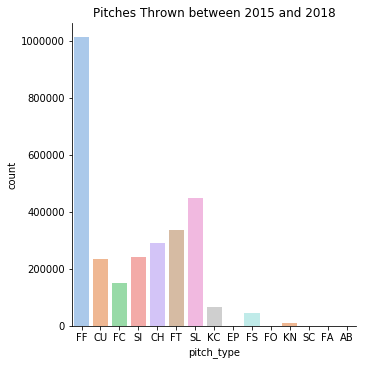

In [17]:
plt.figure(figsize=(15,10))
sns.catplot(x="pitch_type", kind="count", palette="pastel", data=df)
plt.title('Pitches Thrown between 2015 and 2018')
plt.show()

Between 2015 and 2018 the four seam fastball is the most commonly thrown pitch in Major League Baseball. This makes sense as it is typically the backbone of every pitchers' arsenal, it sets up every other pitch and is the least difficult to throw. The most commonly thrown breaking ball is the slider which has gained in popularity over the years. Back in my playing days the curveball was far more common but it has been discovered that the slider is less strain on the arm than the curveball. It is also less difficult to throw. The changeup remains the most popular off speed pitch as it highly effective and can be thrown many different ways to manipulate the movement within the strike zone. 

In [18]:
#group the pitches into different categories to simplify data visualizations
#Explore relationship between pitch velocity and pitch type

offspeed = df.loc[df['pitch_type'].isin(['CH', 'KN', 'EP'])]
breakingballs = df.loc[df['pitch_type'].isin(['CU', 'KC', 'SC', 'SL'])]
fastballs = df.loc[df['pitch_type'].isin(['FC', 'FF', 'FS', 'FT', 'SI', 'FA'])]

In [19]:
fastballs.head()

,ab_id,batter_id,event,g_id,inning,o,p_score,p_throws,pitcher_id,stand,...,pitch_type,event_num,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b
0,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,FF,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,FF,4,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0
2,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,FF,5,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0
3,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,FF,6,0.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0
5,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,FF,8,0.0,2.0,2.0,0.0,6.0,0.0,0.0,0.0


Being a former baseball player and more specifically, pitcher, I have a feeling that velocity and trajectory data will be most important in predicting pitch types. Therefore, I will explore velocity and trajectory in detail below.

### Velocity

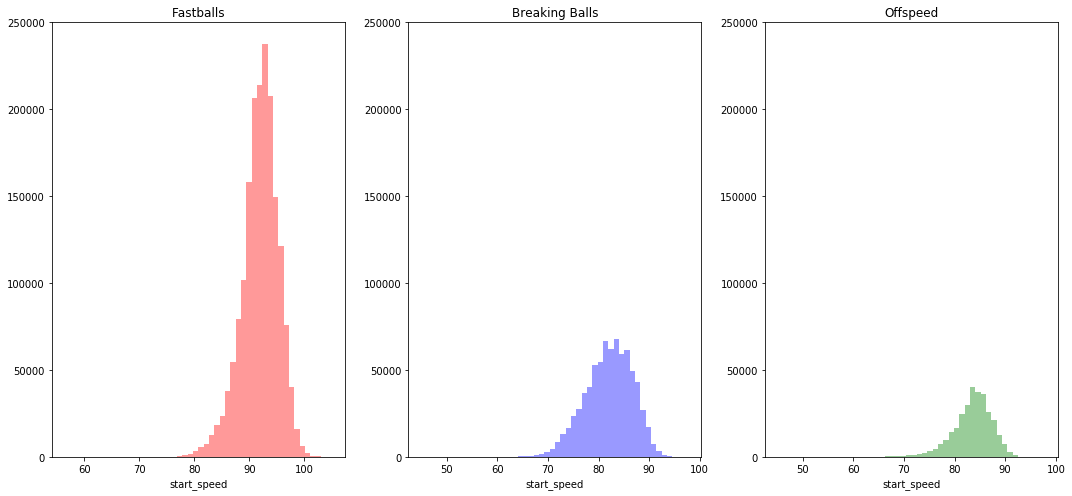

In [20]:
#explore the relationship between velocity and pitch type
#use different colors, scale the images

plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
sns.distplot(fastballs.start_speed, kde=False, color='red')
plt.ylim(0, 250000)
plt.title('Fastballs')

plt.subplot(1,3,2)
sns.distplot(breakingballs.start_speed, kde=False, color='blue')
plt.ylim(0, 250000)
plt.title('Breaking Balls')

plt.subplot(1,3,3)
sns.distplot(offspeed.start_speed, kde=False, color='green')
plt.ylim(0, 250000)
plt.title('Offspeed')

plt.tight_layout()
plt.show()

As shown above, fastballs are the predominant pitch thrown in baseball. When a pitcher has a good fastball they can more effectively throw their off speed and breaking pitches. We can also see the differences in velocity between the different groups of pitches. 

In [21]:
#let's analyze righties vs lefties fastball pitch velocities

lefties = df.loc[df['p_throws'] == 'L']
righties = df.loc[df['p_throws']== 'R']
velocity_L = lefties[['p_throws', 'start_speed', 'pitch_type']]
velocity_R = righties[['p_throws', 'start_speed', 'pitch_type']]

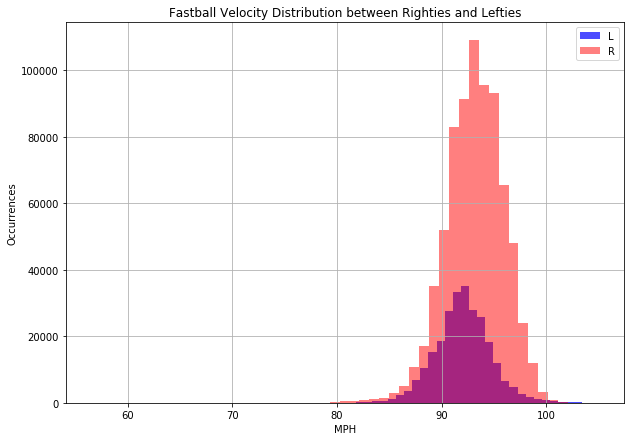

In [22]:
ffvelocity_L = velocity_L.loc[velocity_L['pitch_type']=='FF']
ffvelocity_R = velocity_R.loc[velocity_R['pitch_type']=='FF']

plt.figure(figsize=(10,7))
ffvelocity_L['start_speed'].hist(alpha=0.7, bins=50, label='L', color='B')
ffvelocity_R['start_speed'].hist(alpha=0.5, bins=50, label='R', color='R')
plt.title('Fastball Velocity Distribution between Righties and Lefties')
plt.xlabel('MPH')
plt.ylabel('Occurrences')
plt.legend()

Here, we can see two things... there are many more righties than lefties in baseball, and righties slightly outperform lefties when it comes to fastball velocity. This could be due in part to the fact that lefties are somewhat of a rarity, a unicorn if you will. Lefties are highly sought after in baseball and typically have a lower barrier to entry into the Major Leagues. 

### Trajectory

What makes the pitchFX technology so interesting is that it measures the horizontal and vertical movements of the pitch with the variables pfx_x and pfx_z. Using our data analysis above, we can see that of all the breaking balls, the slider is the most commonly thrown. A slider is a pitch that tails laterally and down in the strike zone. Lets see what the slider looks like in two dimensional space.

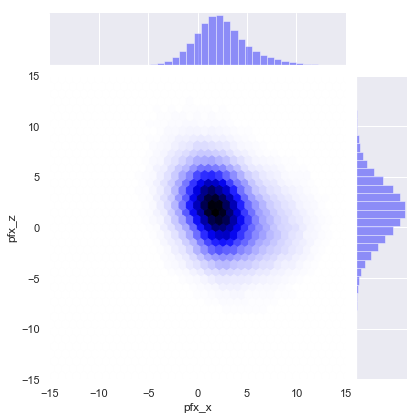

In [23]:
#plot the slider vertical and horizontal movement in 2d space
slider = df[(df.pitch_type == 'SL') & (df.p_throws == 'R')]
sl_movement = slider[['pfx_x', 'pfx_z']]
sns.set()
sns.jointplot(sl_movement['pfx_x'],
              sl_movement['pfx_z'],
              color="blue",
              kind="hex",
              xlim=[-15, 15],
              ylim=[-15, 15])

plt.show()

Based on the visual above we can see that the slider is spread out across horizontal and vertical planes. There is perhaps more variation in the vertical movement(pfx_z) of the slider than the horizontal movement(pfx_x) across the MLB. Sliders are different for every pitcher, some pitchers throw long, sweeping sliders while others throw what is called a 'slurve' - a pitch that will have more downward movement than the traditional slider. Every pitcher has a different release point which will influence the vertical and horizontal movements of their pitches. 

Let's compare this to a fastball and offspeed pitch.

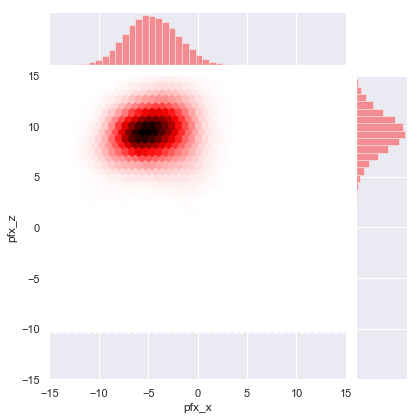

In [24]:
#plot the fastball's horizontal and vertical movement in 2d space
fastball = df[(df.pitch_type == 'FF') & (df.p_throws == 'R')]
ff_movement = fastball[['pfx_x', 'pfx_z']]
sns.jointplot(ff_movement['pfx_x'],
              ff_movement['pfx_z'],
              color="red",
              kind="hex",
              xlim=[-15, 15],
              ylim=[-15, 15],)

plt.show()

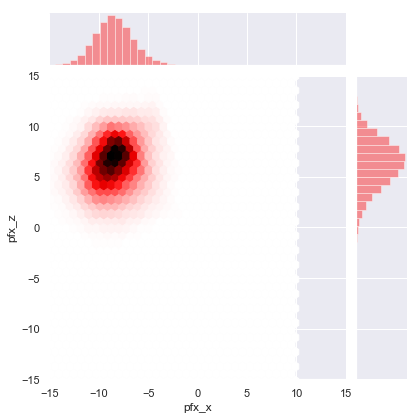

In [25]:
#plot the two seam fastball movement in 2d space
ft = df[(df.pitch_type == 'FT') & (df.p_throws == 'R')]
ft_movement = ft[['pfx_x', 'pfx_z']]

sns.jointplot(ft_movement['pfx_x'],
              ft_movement['pfx_z'],
              color="red",
              kind="hex",
              xlim=[-15, 15],
              ylim=[-15, 15],)

plt.show()

As we can see, the fastball and slider are very different in terms of vertical and horizontal movements. The slider is much more widespread than the fastball meaning its movement varies from pitcher to pitcher more significantly than the fastball. A fastball is a fairly universal pitch because of its grip and release. The slider, however, takes a certain skillset to throw. 


Let's take a look at the curveball.

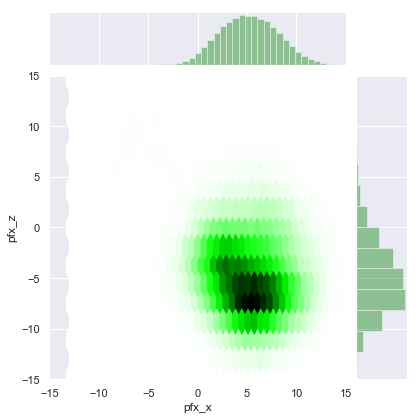

In [26]:
#plot the curveball in 2d space
curveball = df[(df.pitch_type == 'CU') & (df.p_throws == 'R')]
cu_movement = curveball[['pfx_x', 'pfx_z']]
sns.set()
sns.jointplot(cu_movement['pfx_x'],
              cu_movement['pfx_z'],
              color="green",
              kind="hex",
              xlim=[-15, 15],
              ylim=[-15, 15],)

plt.show()

Using the fastball, two seam fastball, slider and curveball movements in space, we can see some noticeable differences using density plots. As expected, trajectory based features may be significant variables for our pitch type clustering algorithms.

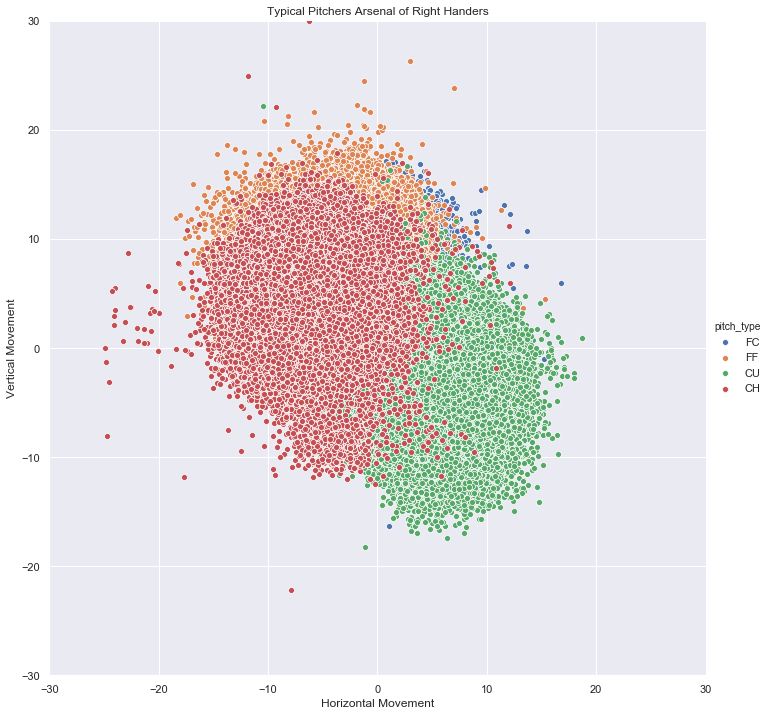

In [27]:
#using a typical pitcher's arsenal, lets see if we can differentiate the pitches based on movement in space with the database labels

pitches = ['CU', 'FF', 'FC', 'CH']
arsenal = df[(df.pitch_type.isin(pitches)) & (df.p_throws == 'R')]

sns.pairplot(x_vars = 'pfx_x',
              y_vars = 'pfx_z',
              hue = 'pitch_type',
              data = arsenal,
            size=10)
plt.title('Typical Pitchers Arsenal of Right Handers')
plt.xlabel('Horizontal Movement')
plt.ylabel('Vertical Movement')
plt.xlim(-30,30)
plt.ylim(-30,30)
plt.show()

Not bad, but as expected, the cut fastball and four seam fastball don't separate too well. Also the changeup overlays the two fastballs. Velocity would help separate the fastballs from the change up, let's see how that works.

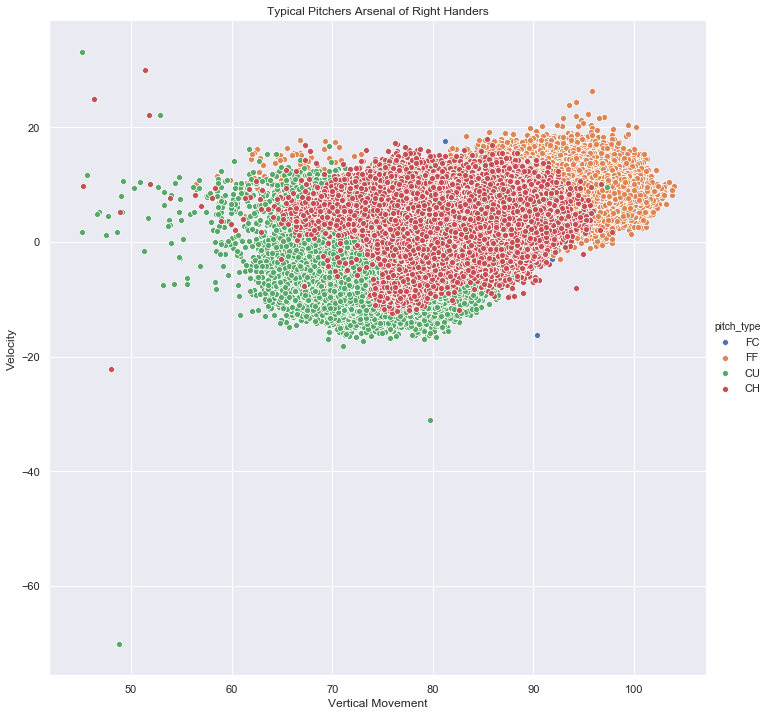

In [28]:
sns.pairplot(x_vars = 'start_speed',
              y_vars = 'pfx_z',
              hue = 'pitch_type',
              data = arsenal,
            size=10)
plt.title('Typical Pitchers Arsenal of Right Handers')
plt.xlabel('Vertical Movement')
plt.ylabel('Velocity')
plt.show()

As we can see, the changeup seems to be better separated from the four seam fastball than it was before using only trajectory variables. However, the cut fastball is missing almost entirely. Let's look at horizontal movement vs velocity.

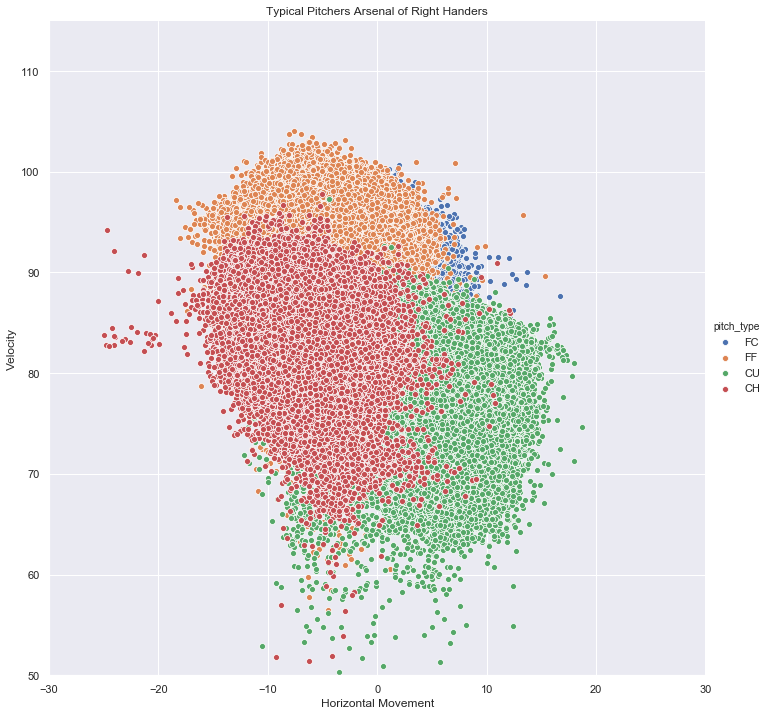

In [29]:
sns.pairplot(x_vars = 'pfx_x',
              y_vars = 'start_speed',
              hue = 'pitch_type',
              data = arsenal,
            size=10)
plt.title('Typical Pitchers Arsenal of Right Handers')
plt.xlabel('Horizontal Movement')
plt.ylabel('Velocity')
plt.xlim(-30,30)
plt.ylim(50,115)
plt.show()

Plotting horizontal movmement vs velocity probably gives us the most separation between these pitches in two dimensional space. Projecting the clustering data onto trajectory features may be helpful in identifying the clusters later on. 

![CraigURL](https://media.giphy.com/media/1Rc370T2WE8sU/giphy.gif "craig")

### Individual Pitcher Analysis

For this project I have decided to analyze Dallas Keuchel's pitches. He is the newest member of my favorite team, the Chicago White Sox so it's only fitting that I explore his pitching arsenal. 

Dallas is a crafty leftie, much like I was in my playing days. He was a member of the 2017 World Champion Houston Astros club and his put up impressive numbers every year since. He is known to eat up innings and keep his team in the ballgame. 

In [31]:
#find each player's id number

pitchers = ['Keuchel']

for p in pitchers:
    print(players[players['last_name']== p])

        id first_name last_name
52  572971     Dallas   Keuchel


In [32]:
#create dataframe for Dallas Keuchel

keuchel = df[df['pitcher_id'] == 572971]

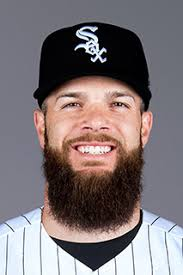

In [33]:
keuchel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11643 entries, 1664 to 2859550
Data columns (total 50 columns):
ab_id              11643 non-null int64
batter_id          11643 non-null int64
event              11643 non-null object
g_id               11643 non-null int64
inning             11643 non-null int64
o                  11643 non-null int64
p_score            11643 non-null int64
p_throws           11643 non-null object
pitcher_id         11643 non-null int64
stand              11643 non-null object
top                11643 non-null bool
px                 11643 non-null float64
pz                 11643 non-null float64
start_speed        11643 non-null float64
end_speed          11643 non-null float64
spin_rate          11643 non-null float64
spin_dir           11643 non-null float64
break_angle        11643 non-null float64
break_length       11643 non-null float64
break_y            11643 non-null float64
ax                 11643 non-null float64
ay                 11643

In [34]:
#drop un-needed features
keuchel = keuchel.drop(['ab_id', 'batter_id', 'event', 'g_id', 'inning', 'o', 'p_score', 'p_throws', 'pitcher_id',
                       'stand', 'top', 'code', 'type', 'event_num'], axis=1)

Let's look at what pitches Dallas Keuchel throws.

In [35]:
#what pitches are in Keuchel's arsenal?

keuchel.pitch_type.unique()

array(['FF', 'FC', 'FT', 'SL', 'CH'], dtype=object)

Keuchel throws a four seam fastball (FF), cut fastball (FC), two seam fastball (FT), slider (SL) and changeup (CH).

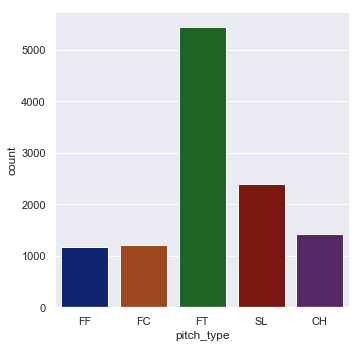

In [36]:
#how often does he throw the pitches?

sns.catplot(x='pitch_type', kind='count', palette='dark', data=keuchel)

Keuchel's predominant pitch is the two seam fastball. The two seam fastball tends to have more movement than the four seam fastball but similar speed. The two seam fastball is a great weapon for a pitcher because there are so many ways to manipulate the rotation of the ball when using the traiditional two seam grip. 

It will be interesting to see if the clustering algorithms will be able to differentiate between his fastballs...

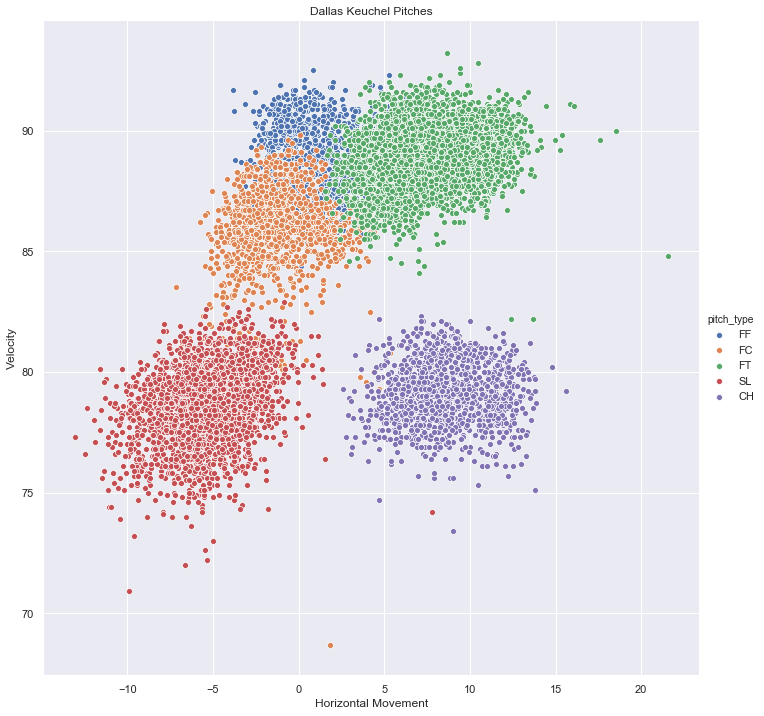

In [37]:
sns.pairplot(x_vars = 'pfx_x',
              y_vars = 'start_speed',
              hue = 'pitch_type',
              data = keuchel,
            size=10)
plt.title('Dallas Keuchel Pitches')
plt.xlabel('Horizontal Movement')
plt.ylabel('Velocity')
plt.show()

Ok, we have some clear separation here when looking at horizontal movement vs velocity. However, if we look closely, we can see there could be an issue with clustering different fastballs together. The two seam and four seam fastballs seem to cluster together to some degree when using the database. This isn't surprising as the two pitches are somewhat arbitrary. You can see from the scatter plot that they are highly comparable in speed and very slightly differ in horizontal movement.

In [42]:
#create dataframe with all numerical features plus our target variable pitch_type

keuchel_num = keuchel.drop(['type_confidence', 'nasty', 'zone', 'b_score', 'b_count', 's_count',
                           'outs', 'on_1b', 'on_2b', 'on_3b'], axis=1)

In [43]:
keuchel_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11643 entries, 1664 to 2859550
Data columns (total 28 columns):
px              11643 non-null float64
pz              11643 non-null float64
start_speed     11643 non-null float64
end_speed       11643 non-null float64
spin_rate       11643 non-null float64
spin_dir        11643 non-null float64
break_angle     11643 non-null float64
break_length    11643 non-null float64
break_y         11643 non-null float64
ax              11643 non-null float64
ay              11643 non-null float64
az              11643 non-null float64
sz_bot          11643 non-null float64
sz_top          11643 non-null float64
vx0             11643 non-null float64
vy0             11643 non-null float64
vz0             11643 non-null float64
x               11643 non-null float64
x0              11643 non-null float64
y               11643 non-null float64
y0              11643 non-null float64
z0              11643 non-null float64
pfx_x           11643 non-nu

In [44]:
#define variables

Xdk = keuchel_num.drop(['pitch_type'], axis=1)
ydk = keuchel_num['pitch_type']

In [45]:
# import pca
from sklearn.decomposition import PCA

#perform pca
pca = PCA()
Xdk_std = StandardScaler().fit_transform(Xdk)
dk_pca = pca.fit(Xdk_std)

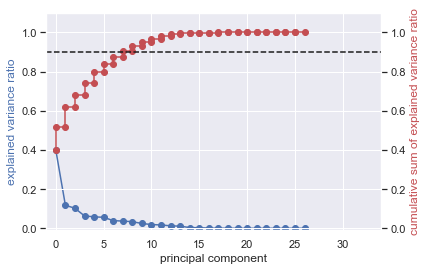

In [46]:
# plot variance ratio against principal component
fig, ax1 = plt.subplots()
ax1.plot(dk_pca.explained_variance_ratio_, "o-", color="b")
ax1.set_xlabel("principal component")
ax1.set_ylabel("explained variance ratio")
ax1.set_ylim([-0.01, 1.1])
ax1.yaxis.label.set_color('b')

# plot cumulative sum of explained variance ratio against principal component
ax2 = ax1.twinx()
ax2.step(np.cumsum(dk_pca.explained_variance_ratio_), "o-", color="r")
ax2.set_ylabel("cumulative sum of explained variance ratio")
ax2.set_xlim([-1, 34])
ax2.set_ylim([-0.01, 1.1])
ax2.yaxis.label.set_color('r')
ax2.axhline(y=0.9, color="k", ls="dashed")
plt.show()

In [47]:
var = dk_pca.explained_variance_ratio_
var

array([3.99392111e-01, 1.17869123e-01, 1.02131030e-01, 6.32403425e-02,
       5.83937592e-02, 5.62163304e-02, 3.90328747e-02, 3.68926260e-02,
       3.36273865e-02, 2.45650124e-02, 1.90567185e-02, 1.70319625e-02,
       1.24988228e-02, 1.09599472e-02, 3.57526164e-03, 3.05608219e-03,
       9.71186001e-04, 6.02187212e-04, 4.62612142e-04, 1.24258944e-04,
       9.21874624e-05, 7.21168225e-05, 4.91175199e-05, 3.53404121e-05,
       2.78216430e-05, 1.38134116e-05, 9.96686992e-06])

Looks as if the 1st component accounts for almost 40% of the variance in the data while the second component holds about 12%. This is a significant dropoff. Let's take a look to see how PCA is grouping the components. Note that it takes 10 principal components to explain 90% of the variance in the data. 

Let's take a look at the first nine components and how PCA is loading them.

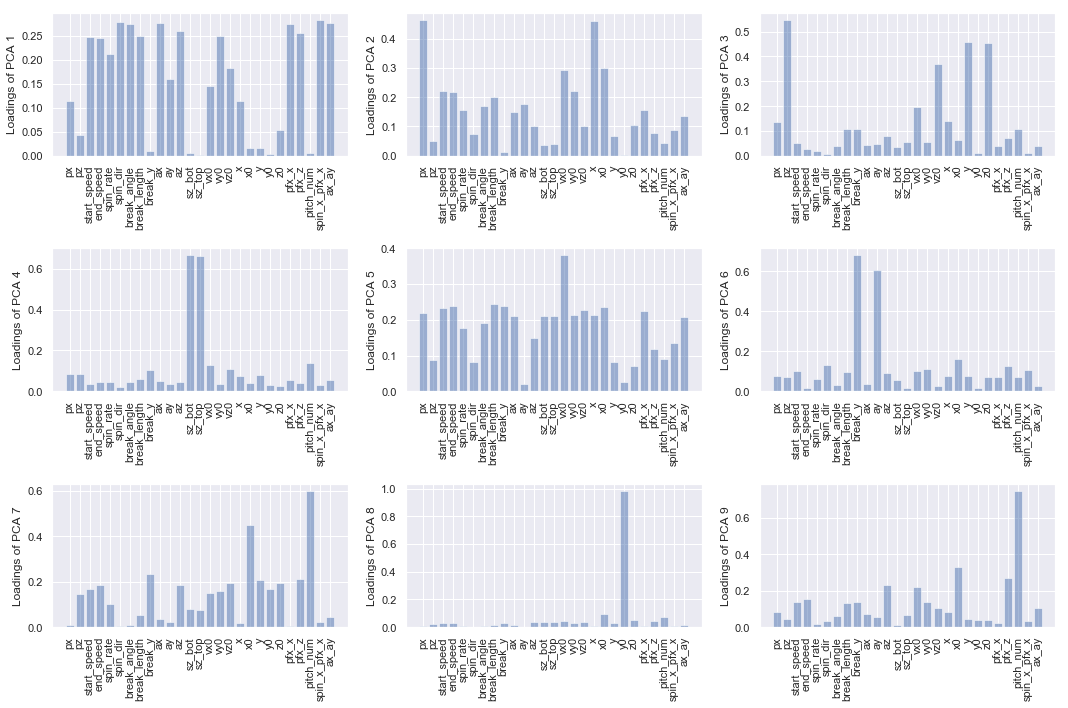

In [48]:
# intialize figure
fig, ax = plt.subplots(3, 3, figsize=(15, 10))

# plot loadings
for ii in range(3):
    for jj in range(3):
        loadings = dk_pca.components_[3*ii+jj, :]
        # plot barchart of loadings
        ax[ii, jj].bar(range(len(loadings)), np.abs(loadings), align='center', alpha=0.5)
        ax[ii, jj].set_ylabel("Loadings of PCA %s" %(3*ii+jj+1))
        plt.sca(ax[ii, jj])
        plt.xticks(range(len(loadings)), list(Xdk), rotation=90)
        
plt.tight_layout()
plt.show()

Notice that the first principal component, which explains about 40% of the variance, is trajectory feature heavy. Hmmmm...

Plot the first two components in PCA space, labelling the pitch type by the database.

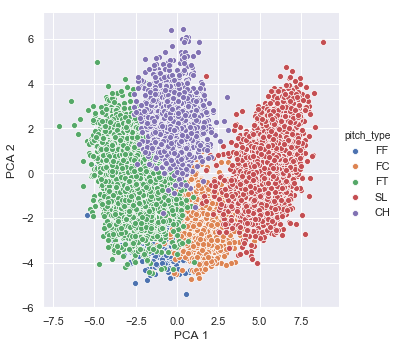

In [49]:
# create dataframe for plotting
pca_df = pd.DataFrame({"pca1":np.dot(Xdk_std , dk_pca.components_[0, :]),
                      "pca2":np.dot(Xdk_std , dk_pca.components_[1, :]),
                      "pitch_type":np.array(keuchel.pitch_type)})

# plot in pca
sns.pairplot(x_vars="pca1", y_vars="pca2", data=pca_df, hue="pitch_type", size=5)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

As we can see, the 1st component seems to better separate than the second in "PCA space". It seems as if pitch types are best separated in the 1st component, which is trajectory heavy information. 

In [50]:
#process only trajectory based features with pca

pca = PCA()
Xdk_traj = Xdk.drop(['break_y', 'sz_bot', 'sz_top', 'x', 'y', 'x0', 'y0', 'z0', 'pitch_num'], axis=1)
Xdk_traj_std = StandardScaler().fit_transform(Xdk_traj)
Xdk_traj_pca = pca.fit(Xdk_traj_std)

UMAP with  5 neighbors and  0.05 minimum distance.


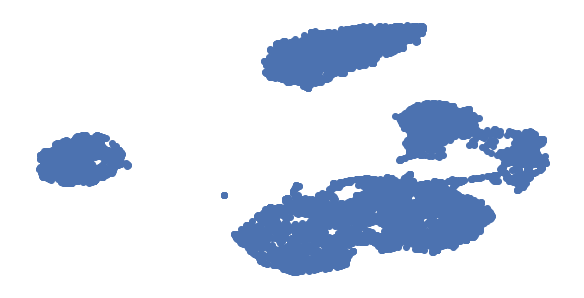



UMAP with  5 neighbors and  0.1 minimum distance.


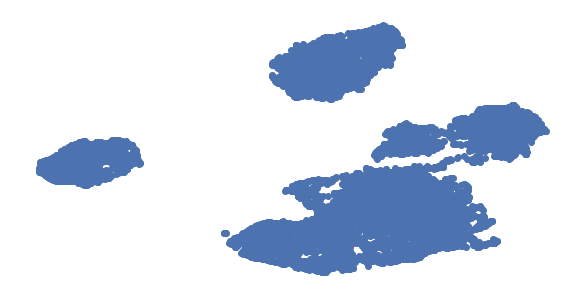



UMAP with  5 neighbors and  0.25 minimum distance.


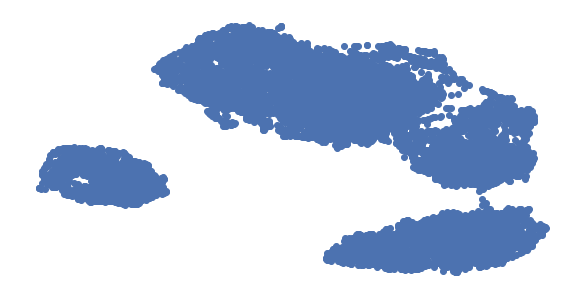



UMAP with  5 neighbors and  0.5 minimum distance.


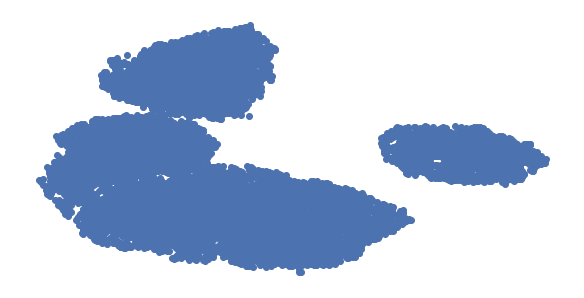



UMAP with  25 neighbors and  0.05 minimum distance.


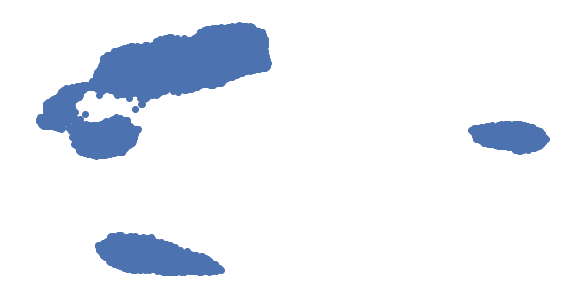



UMAP with  25 neighbors and  0.1 minimum distance.


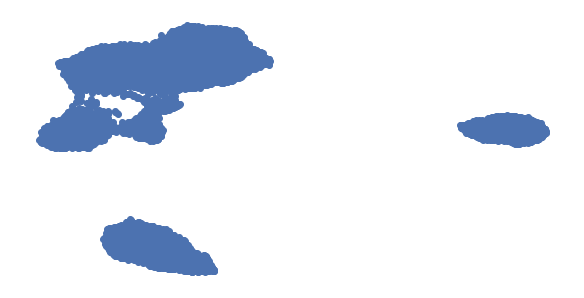



UMAP with  25 neighbors and  0.25 minimum distance.


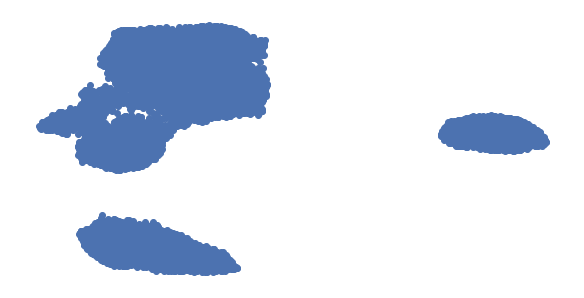



UMAP with  25 neighbors and  0.5 minimum distance.


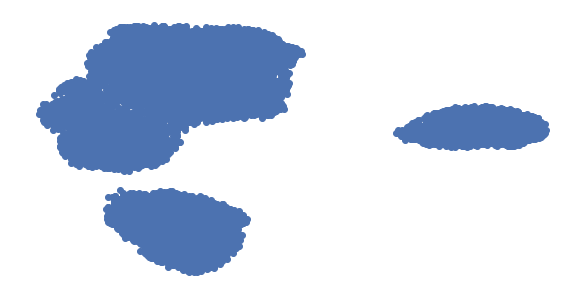



UMAP with  50 neighbors and  0.05 minimum distance.


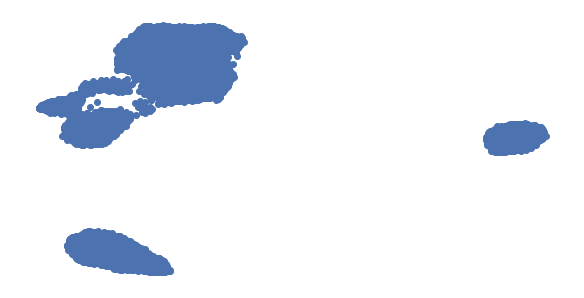



UMAP with  50 neighbors and  0.1 minimum distance.


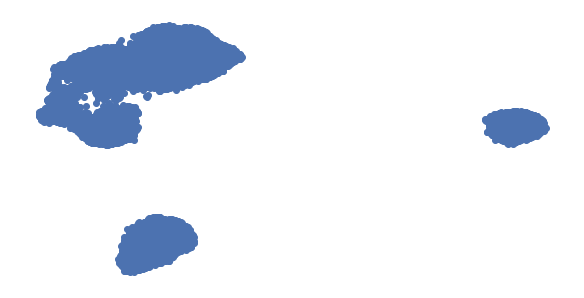



UMAP with  50 neighbors and  0.25 minimum distance.


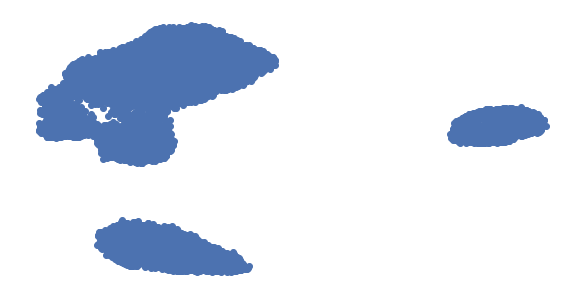



UMAP with  50 neighbors and  0.5 minimum distance.


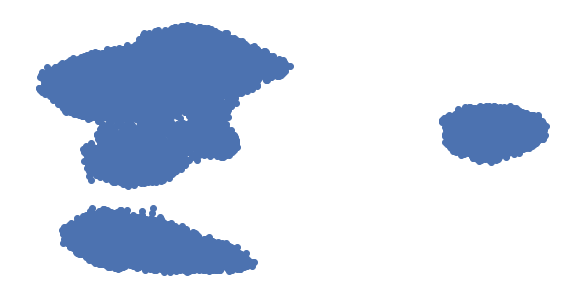



UMAP with  100 neighbors and  0.05 minimum distance.


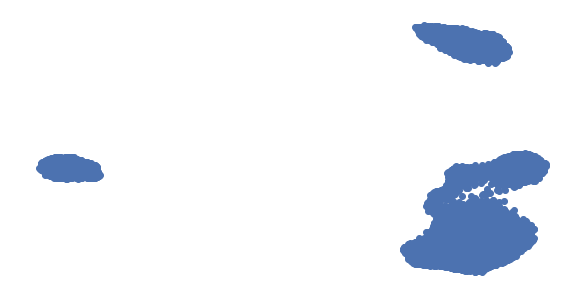



UMAP with  100 neighbors and  0.1 minimum distance.


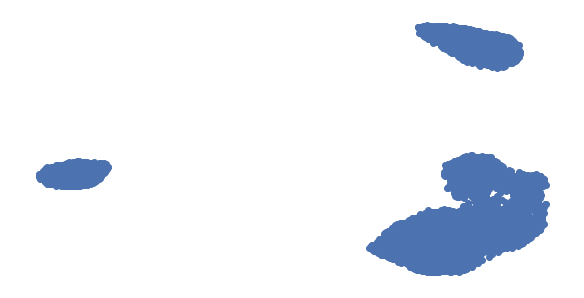



UMAP with  100 neighbors and  0.25 minimum distance.


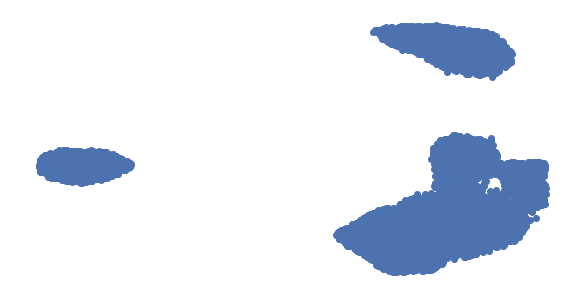



UMAP with  100 neighbors and  0.5 minimum distance.


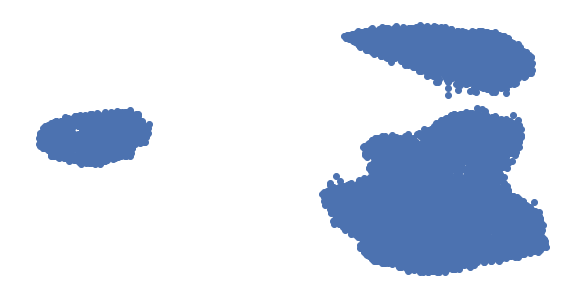

In [144]:
#find optimal parameters for umap reduction
import umap

for n_neighbors in [5, 25, 50, 100]:
    for min_dist in [0.05, 0.1, 0.25, 0.5]:
        umap_results = umap.UMAP(n_neighbors=n_neighbors,
                      min_dist=min_dist,
                      metric='euclidean').fit_transform(Xdk_traj_std)
        print('UMAP with ', n_neighbors, 'neighbors and ', min_dist, 'minimum distance.')
        plt.figure(figsize=(10,5))
        plt.scatter(umap_results[:, 0], umap_results[:, 1])
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')
        plt.show()
        print('\n')

In [145]:
import umap

umap_results = umap.UMAP(n_neighbors=25,
                      min_dist=0.1,
                      metric='euclidean').fit_transform(Xdk_traj_std)

In [51]:
Xdk_traj.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11643 entries, 1664 to 2859550
Data columns (total 18 columns):
px              11643 non-null float64
pz              11643 non-null float64
start_speed     11643 non-null float64
end_speed       11643 non-null float64
spin_rate       11643 non-null float64
spin_dir        11643 non-null float64
break_angle     11643 non-null float64
break_length    11643 non-null float64
ax              11643 non-null float64
ay              11643 non-null float64
az              11643 non-null float64
vx0             11643 non-null float64
vy0             11643 non-null float64
vz0             11643 non-null float64
pfx_x           11643 non-null float64
pfx_z           11643 non-null float64
spin_x_pfx_x    11643 non-null float64
ax_ay           11643 non-null float64
dtypes: float64(18)
memory usage: 2.0 MB


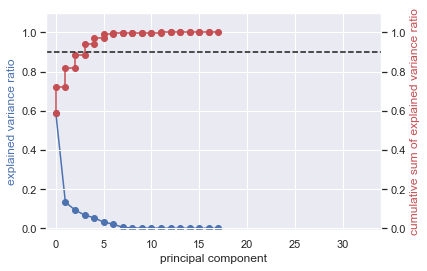

In [52]:
# plot variance ratio against principal component
fig, ax1 = plt.subplots()
ax1.plot(Xdk_traj_pca.explained_variance_ratio_, "o-", color="b")
ax1.set_xlabel("principal component")
ax1.set_ylabel("explained variance ratio")
ax1.set_ylim([-0.01, 1.1])
ax1.yaxis.label.set_color('b')

# plot cumulative sum of explained variance ratio against principal component
ax2 = ax1.twinx()
ax2.step(np.cumsum(Xdk_traj_pca.explained_variance_ratio_), "o-", color="r")
ax2.set_ylabel("cumulative sum of explained variance ratio")
ax2.set_xlim([-1, 34])
ax2.set_ylim([-0.01, 1.1])
ax2.yaxis.label.set_color('r')
ax2.axhline(y=0.9, color="k", ls="dashed")
plt.show()

In [53]:
var = Xdk_traj_pca.explained_variance_ratio_
var

array([5.89965345e-01, 1.33084250e-01, 9.38764577e-02, 6.76616648e-02,
       5.39037861e-02, 3.14032734e-02, 2.14235895e-02, 4.66281652e-03,
       1.49754381e-03, 8.83423308e-04, 7.08242050e-04, 4.18577582e-04,
       1.82697006e-04, 1.35367786e-04, 1.01674221e-04, 5.07756480e-05,
       2.38360588e-05, 1.66794178e-05])

As can be seen above, it would take 6 principal components to explain 90% of the variance using trajectory based features. Let's take a look again at the PCA loadings.

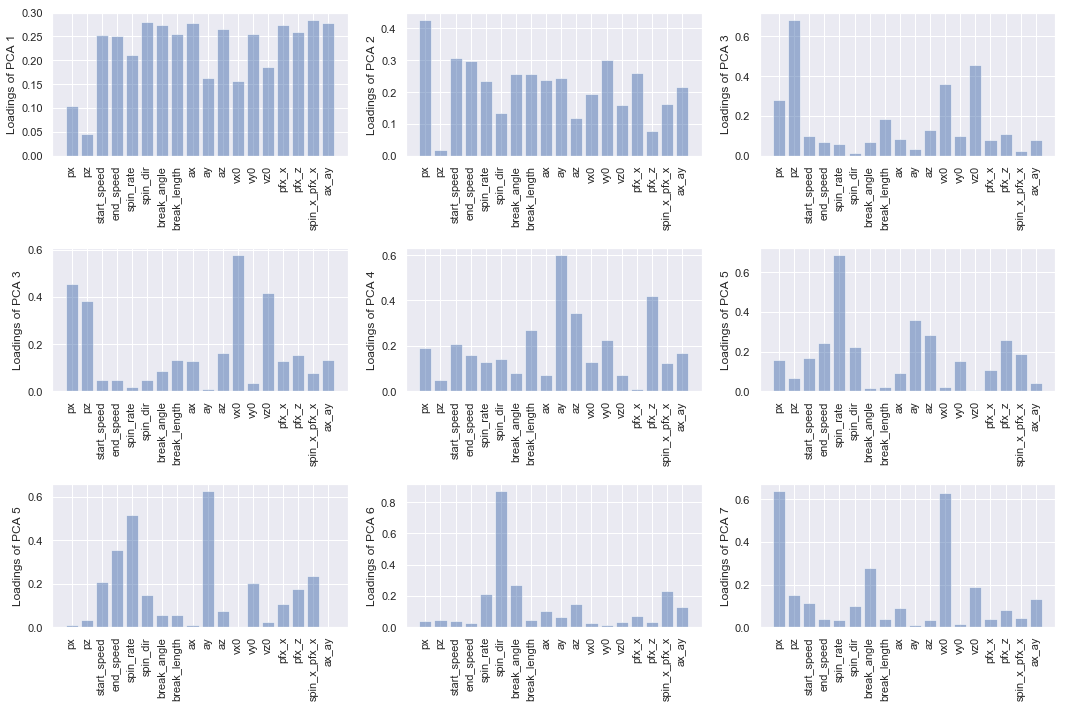

In [54]:
# intialize figure
fig, ax = plt.subplots(3, 3, figsize=(15, 10))

# plot loadings
for ii in range(3):
    for jj in range(3):
        loadings = Xdk_traj_pca.components_[3*ii+jj, :]
        # plot barchart of loadings
        ax[ii, jj].bar(range(len(loadings)), np.abs(loadings), align='center', alpha=0.5)
        ax[ii, jj].set_ylabel("Loadings of PCA %s" %(2*ii+jj+1))
        plt.sca(ax[ii, jj])
        plt.xticks(range(len(loadings)), list(Xdk_traj), rotation=90)
        
plt.tight_layout()
plt.show()

### Clustering Pitch Types

### Kmeans 

In [56]:
Xdk_traj.columns.unique()

Index(['px', 'pz', 'start_speed', 'end_speed', 'spin_rate', 'spin_dir',
       'break_angle', 'break_length', 'ax', 'ay', 'az', 'vx0', 'vy0', 'vz0',
       'pfx_x', 'pfx_z', 'spin_x_pfx_x', 'ax_ay'],
      dtype='object')

In [57]:
#Apply PCA for dimensionality reduction, retain 90% of the variance
X_pca = PCA(0.9).fit_transform(Xdk_traj_std)

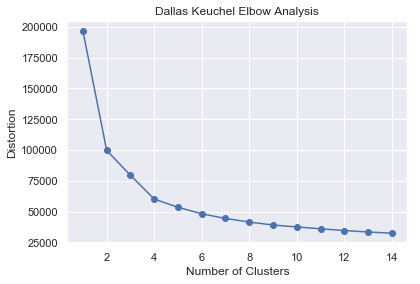

In [58]:
from sklearn.cluster import KMeans, MiniBatchKMeans

#using the elbow method, determine optimal number of clusters

distortions = []
for i in range (1, 15):
    km = KMeans(n_clusters=i,
               init='k-means++',
               n_init=10,
               max_iter=300,
               random_state=13)
    km.fit(X_pca)
    distortions.append(km.inertia_)
plt.plot(range(1, 15), distortions, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.title('Dallas Keuchel Elbow Analysis PCA Reduction')
plt.show()

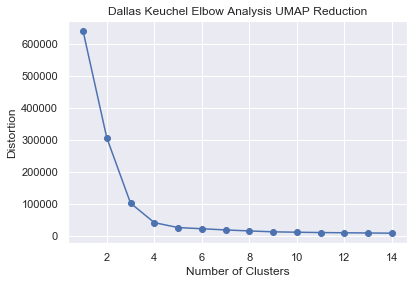

In [146]:
distortions = []
for i in range (1, 15):
    km = KMeans(n_clusters=i,
               init='k-means++',
               n_init=10,
               max_iter=300,
               random_state=13)
    km.fit(umap_results)
    distortions.append(km.inertia_)
plt.plot(range(1, 15), distortions, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.title('Dallas Keuchel Elbow Analysis UMAP Reduction')
plt.show()

According to the elbow method, the ideal clusters is probably somewhere around 4. Note that according to our EDA above, Dallas Keuchel throws five different pitches. 

In [59]:
from sklearn import metrics

# test silhouette and ARI scores of possible clusters using pca components

clusters = [3, 4, 5, 6]
for cluster in clusters:
    predk = KMeans(n_clusters=cluster, init='k-means++', n_init=10, max_iter=300,
               random_state=13).fit_predict(X_pca)
    print('Kmeans', cluster, 'clusters')
    print('ARI Score: {}' .format(metrics.adjusted_rand_score(ydk, predk)))
    print('Silhouette Score: {}'.format(metrics.silhouette_score(X_pca, predk, metric='euclidean')))
    print('------------------')

Kmeans 3 clusters
ARI Score: 0.5958092961896378
Silhouette Score: 0.32458173741164426
------------------
Kmeans 4 clusters
ARI Score: 0.8083788451112779
Silhouette Score: 0.37878769665686357
------------------
Kmeans 5 clusters
ARI Score: 0.5763419640735478
Silhouette Score: 0.30190206363155536
------------------
Kmeans 6 clusters
ARI Score: 0.5166541877662252
Silhouette Score: 0.2624590075660608
------------------


In [226]:
# test silhouette and ARI scores of possible clusters using umap

clusters = [3, 4, 5, 6]
for cluster in clusters:
    predku = KMeans(n_clusters=cluster, init='k-means++', n_init=10, max_iter=300,
               random_state=13).fit_predict(umap_results)
    print('Kmeans', cluster, 'clusters')
    print('ARI Score: {}' .format(metrics.adjusted_rand_score(ydk, predku)))
    print('Silhouette Score: {}'.format(metrics.silhouette_score(umap_results, predku, metric='euclidean')))
    print('------------------')

Kmeans 3 clusters
ARI Score: 0.5814758306301655
Silhouette Score: 0.7158516049385071
------------------
Kmeans 4 clusters
ARI Score: 0.8653951750647354
Silhouette Score: 0.6559740304946899
------------------
Kmeans 5 clusters
ARI Score: 0.6131407399566938
Silhouette Score: 0.6095044612884521
------------------
Kmeans 6 clusters
ARI Score: 0.5057585807361052
Silhouette Score: 0.5581467151641846
------------------


Seems like Kmeans performs best with 4 clusters when inputting pca and umap components, but since we know that Dallas throws five pitches, let's see how the clustering looks with some visualizations.

In [130]:
# Define the KMeans
dk_kmeans = KMeans(n_clusters=5, random_state=123, init='k-means++', n_init=10, max_iter=300)

# Fit model
%timeit dk_kmeans.fit(X_pca)
y_pred = dk_kmeans.predict(X_pca)

295 ms ± 19.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [148]:
# Define the KMeans
dk_kmeans = KMeans(n_clusters=5, random_state=123, init='k-means++', n_init=10, max_iter=300)

# Fit model
%timeit dk_kmeans.fit(umap_results)
y_predumap = dk_kmeans.predict(umap_results)

110 ms ± 1.67 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


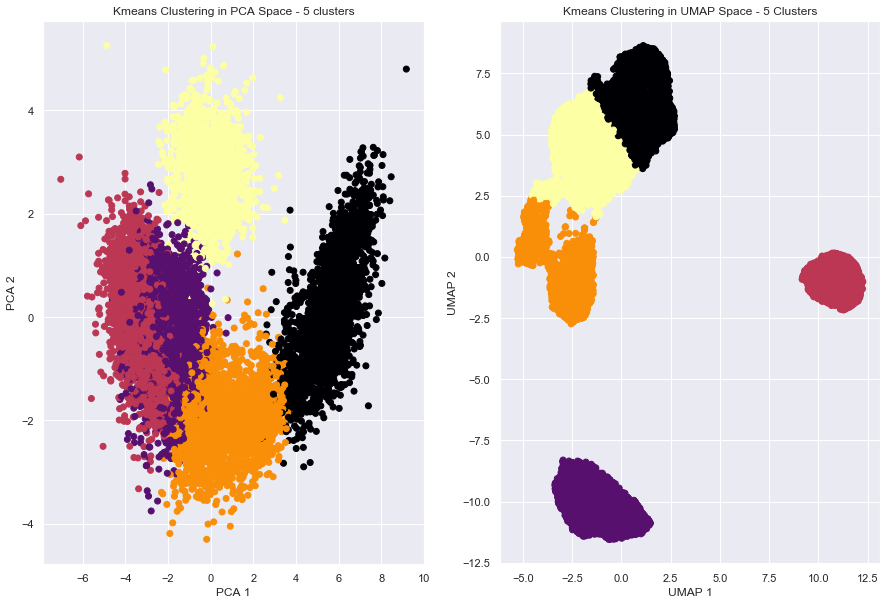

<Figure size 432x288 with 0 Axes>

In [179]:
# Plot the data
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, cmap='inferno')
plt.title('Kmeans Clustering in PCA Space - 5 clusters')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.subplot(1,2,2)
plt.scatter(umap_results[:, 0], umap_results[:, 1], c=y_predumap, cmap='inferno')
plt.title('Kmeans Clustering in UMAP Space - 5 Clusters')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

plt.show()
plt.tight_layout()

In [173]:
print(pd.crosstab(y_pred, ydk))

pitch_type    CH    FC   FF    FT    SL
row_0                                  
0              0    28    0     0  2349
1              0    22  488  2760     0
2              1     0   46  2534     0
3              0  1146  641   141    43
4           1428     7    0     7     2


In [174]:
print(pd.crosstab(y_predumap, ydk))

pitch_type    CH    FC   FF    FT    SL
row_0                                  
0              0     0   28  2446     0
1              0    43    0     0  2390
2           1429     7    0     3     3
3              0  1134  904    77     1
4              0    19  243  2916     0


My intuition was correct, Kmeans seems to do a great job separating Dallas' change up and slider from his fastballs. But the fastballs get a bit messy. The model seems to separate the slider and change while it has trouble dinstinguishing between the three fastballs that Dallas throws.

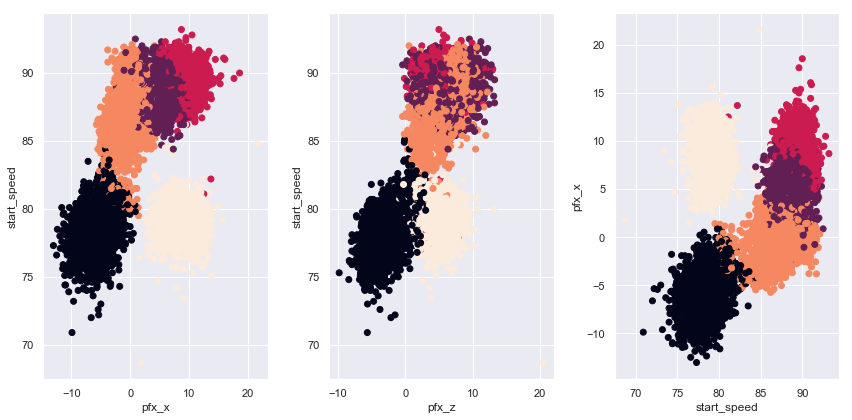

In [175]:
#project the clustering onto horizontal movement, vertical movement, and start speed features

plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.scatter(keuchel['pfx_x'], keuchel['start_speed'], c=y_pred)
plt.xlabel('pfx_x')
plt.ylabel('start_speed')

plt.subplot(1,3,2)
plt.scatter(keuchel['pfx_z'], keuchel['start_speed'], c=y_pred)
plt.xlabel('pfx_z') 
plt.ylabel('start_speed')

plt.subplot(1,3,3)
plt.scatter(keuchel['start_speed'], keuchel['pfx_x'], c=y_pred)
plt.xlabel('start_speed')
plt.ylabel('pfx_x')

plt.tight_layout()
plt.show()

The above graph shows our Kmeans clustering projected onto various features in 2d space. As we can see, the Kmeans algorithm does a reasonable job clustering Dallas Keuchel's pitches. It seems as if it has trouble distinguishing between fastballs, which are likely the red, purple and orange clusters. Keuchel throws three different fastballs - the four seam fastball, two seam fastball and a cut fastball. The cut fastball will have similar movement to his slider but faster so that would mean the black cluster is his slider. That leaves the tan cluster as his change up.

### Hierarchical Clustering

In [103]:
from sklearn.cluster import AgglomerativeClustering
#test different parameters using pca components

groups = [3, 4, 5, 6]

for cluster in groups:
    agg_cluster = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=cluster)
    clusters = agg_cluster.fit_predict(X_pca)
    print('Agg Cluster with ward linkage and', cluster, 'clusters')
    print('ARI Score: {}' .format(metrics.adjusted_rand_score(ydk, clusters)))
    print('Silhouette Score: {}'.format(metrics.silhouette_score(X_pca, clusters, metric='euclidean')))
    print('\n')

Agg Cluster with ward linkage and 3 clusters
ARI Score: 0.6146066573828981
Silhouette Score: 0.31937934314266253


Agg Cluster with ward linkage and 4 clusters
ARI Score: 0.8535609597285556
Silhouette Score: 0.36807303179671774


Agg Cluster with ward linkage and 5 clusters
ARI Score: 0.6317755625903582
Silhouette Score: 0.2869516024161662


Agg Cluster with ward linkage and 6 clusters
ARI Score: 0.571250336334446
Silhouette Score: 0.23933156059462485




In [151]:
#test different parameters using umap components
groups = [3, 4, 5, 6]

for cluster in groups:
    agg_cluster = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=cluster)
    clusters = agg_cluster.fit_predict(umap_results)
    print('Agg Cluster with ward linkage and', cluster, 'clusters')
    print('ARI Score: {}' .format(metrics.adjusted_rand_score(ydk, clusters)))
    print('Silhouette Score: {}'.format(metrics.silhouette_score(umap_results, clusters, metric='euclidean')))
    print('\n')

Agg Cluster with ward linkage and 3 clusters
ARI Score: 0.5814758306301655
Silhouette Score: 0.7158516049385071


Agg Cluster with ward linkage and 4 clusters
ARI Score: 0.8931390484408103
Silhouette Score: 0.6605943441390991


Agg Cluster with ward linkage and 5 clusters
ARI Score: 0.6205906730470313
Silhouette Score: 0.5869231224060059


Agg Cluster with ward linkage and 6 clusters
ARI Score: 0.638830170612376
Silhouette Score: 0.5757510662078857




In [107]:
from sklearn.cluster import AgglomerativeClustering
#test different parameters

linkage = ['complete', 'average']
aff = ['euclidean', 'cosine', 'manhattan']
groups = [3, 4, 5, 6]
for link in linkage:
    for aff in affinity:
        for cluster in groups:
            agg_cluster = AgglomerativeClustering(linkage=link, 
                                      affinity=aff,
                                      n_clusters=cluster)
            clusters = agg_cluster.fit_predict(X_pca)
            print('Agg Cluster with', link, 'linkage and', cluster, 'clusters', aff, 'affinity')
            print('ARI Score: {}' .format(metrics.adjusted_rand_score(ydk, clusters)))
            print('Silhouette Score: {}'.format(metrics.silhouette_score(X_pca, clusters)))
            print('\n')

Agg Cluster with complete linkage and 3 clusters euclidean affinity
ARI Score: 0.539932128951226
Silhouette Score: 0.34459401973371656


Agg Cluster with complete linkage and 4 clusters euclidean affinity
ARI Score: 0.5474050575707282
Silhouette Score: 0.25499331285124865


Agg Cluster with complete linkage and 5 clusters euclidean affinity
ARI Score: 0.6768139886640449
Silhouette Score: 0.2534916711932037


Agg Cluster with complete linkage and 6 clusters euclidean affinity
ARI Score: 0.44881162698467303
Silhouette Score: 0.12868918471674937


Agg Cluster with complete linkage and 3 clusters cosine affinity
ARI Score: 0.6624806716866378
Silhouette Score: 0.31857440498666095


Agg Cluster with complete linkage and 4 clusters cosine affinity
ARI Score: 0.7088973282857528
Silhouette Score: 0.25113471707650137


Agg Cluster with complete linkage and 5 clusters cosine affinity
ARI Score: 0.6870175641031265
Silhouette Score: 0.252052745619227


Agg Cluster with complete linkage and 6 cluste

Using ARI and silhouette scores as the guiding metrics, we can safely say the ward linkage works best with this data.

In [176]:
# Defining the agglomerative clustering
agg_cluster_5 = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=5)


agg_cluster_5umap = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=5)

# Fit models
agg_cluster_5.fit(X_pca)
y_pred_agg5 = agg_cluster_5.fit_predict(X_pca)

agg_cluster_5umap.fit(umap_results)
y_pred_agg5umap = agg_cluster_5.fit_predict(umap_results)

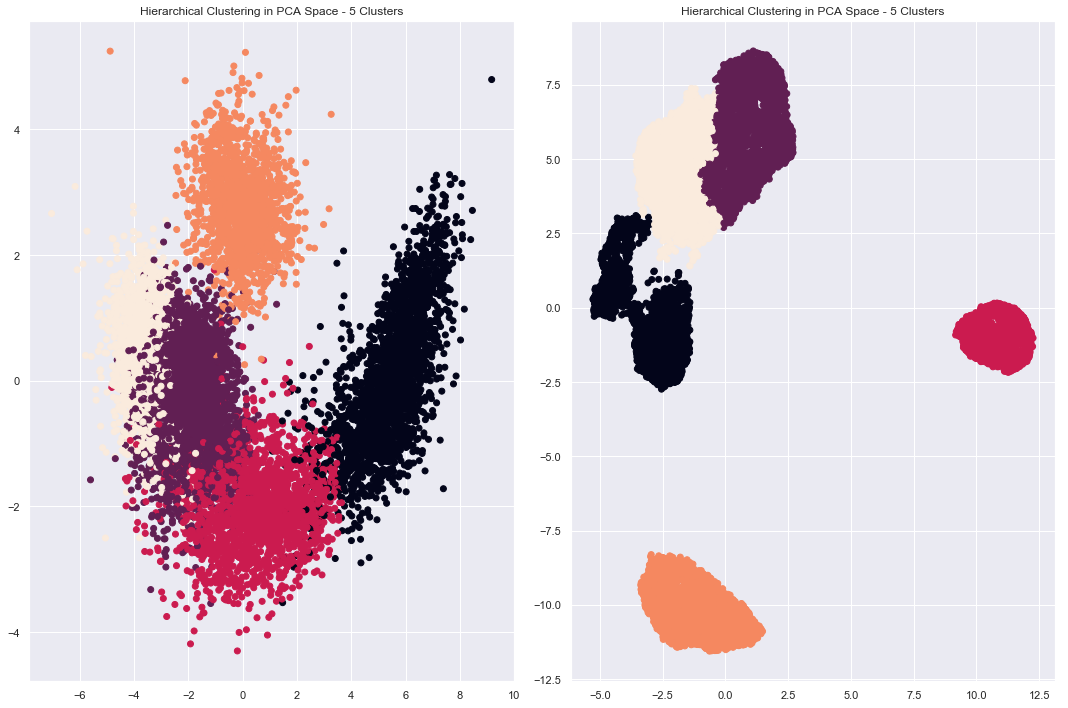

In [178]:
# Visualize the clustering via pca and umap reduction

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_agg5)
plt.title('Hierarchical Clustering in PCA Space - 5 Clusters')

plt.subplot(1,2,2)
plt.scatter(umap_results[:, 0], umap_results[:, 1], c=y_pred_agg5umap)
plt.title('Hierarchical Clustering in PCA Space - 5 Clusters')

plt.tight_layout()
plt.show()

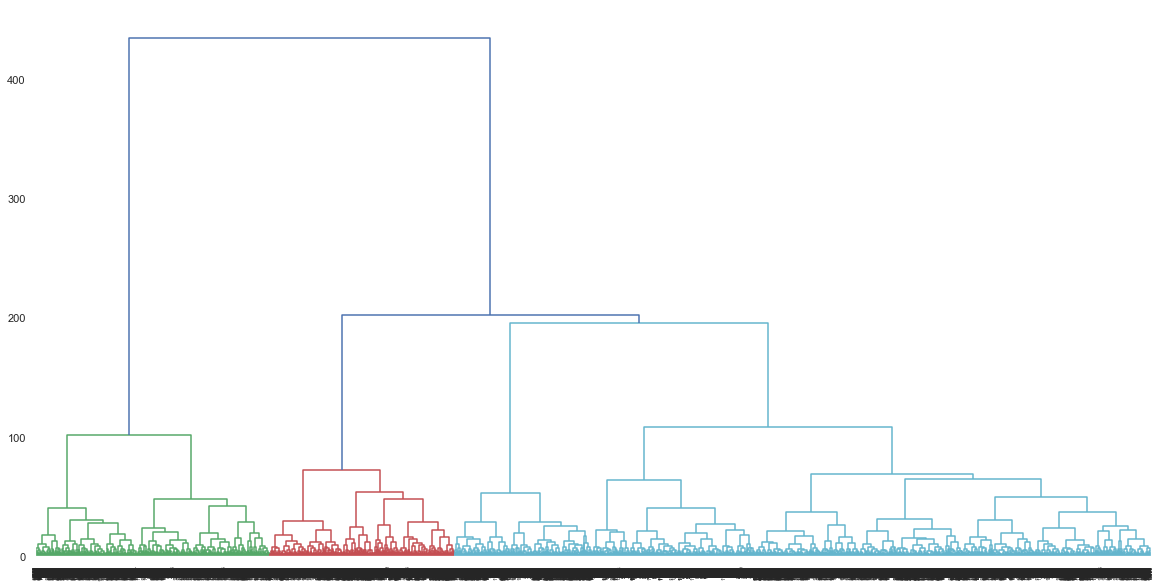

In [182]:
from scipy.cluster.hierarchy import dendrogram, linkage
hclustdk = linkage(X_pca, method='ward', metric='euclidean')

plt.figure(figsize=(20,10))
dendrogram(hclustdk, color_threshold=200)
plt.show()

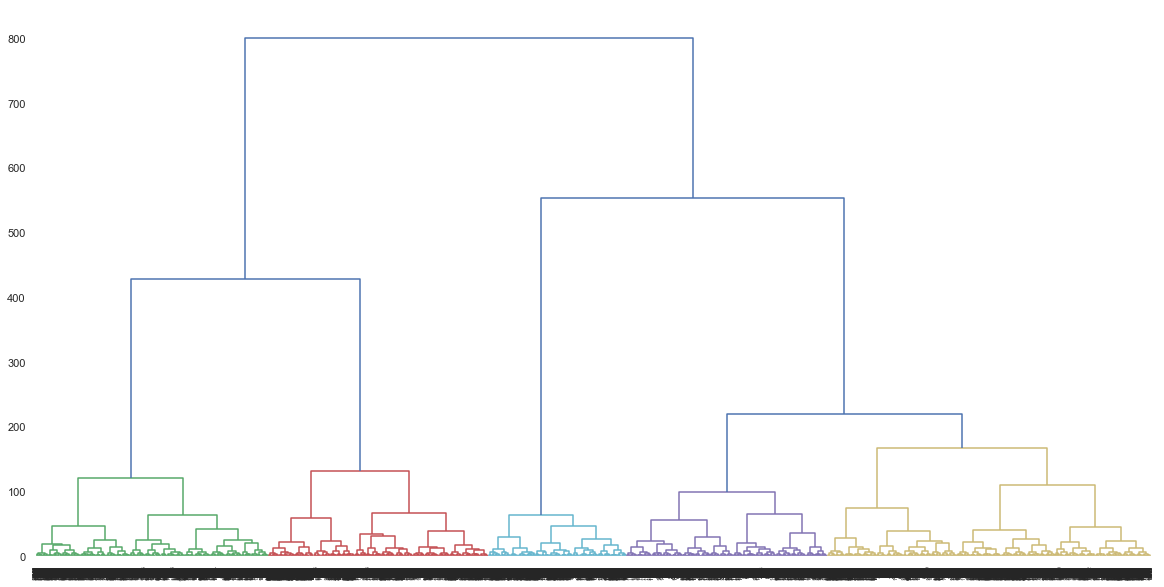

In [141]:
hclustdku = linkage(umap_results, method='ward', metric='euclidean')

plt.figure(figsize=(20,10))
dendrogram(hclustdku, color_threshold=200)
plt.show()

In [180]:
print(pd.crosstab(y_pred_agg5, ydk))

pitch_type    CH    FC   FF    FT    SL
row_0                                  
0              0    59    0     0  2392
1              0    57  379  3691     0
2              0  1082  787    57     1
3           1429     5    0     4     1
4              0     0    9  1690     0


In [181]:
print(pd.crosstab(y_pred_agg5umap, ydk))

pitch_type    CH    FC    FF    FT    SL
row_0                                   
0              0  1128  1037    89     1
1              0     0    14  2706     0
2           1429     7     0     3     3
3              0    43     0     0  2390
4              0    25   124  2644     0


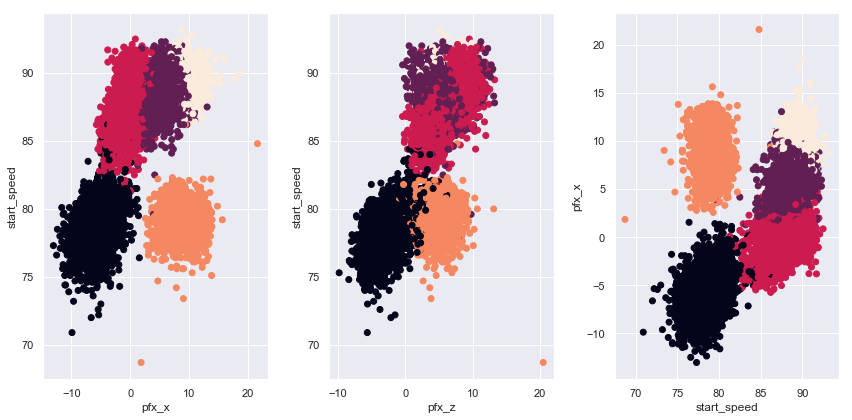

In [191]:
#project the clustering onto horizontal movement and start speed features

plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.scatter(keuchel['pfx_x'], keuchel['start_speed'], c=y_pred_agg5)
plt.xlabel('pfx_x')
plt.ylabel('start_speed')

plt.subplot(1,3,2)
plt.scatter(keuchel['pfx_z'], keuchel['start_speed'], c=y_pred_agg5)
plt.xlabel('pfx_z')
plt.ylabel('start_speed')

plt.subplot(1,3,3)
plt.scatter(keuchel['start_speed'], keuchel['pfx_x'], c=y_pred_agg5)
plt.xlabel('start_speed')
plt.ylabel('pfx_x')

plt.tight_layout()
plt.show()

Above we can again see the clusters plotted onto the trajectory features. The tan, purple and red clusters are his fastballs, the black his slider and the orange his change up. 

### DBScan

In [74]:
#let's start by finding the ideal value for the DBScan parameter, eps
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_pca)
distances, indices = nbrs.kneighbors(X_pca)

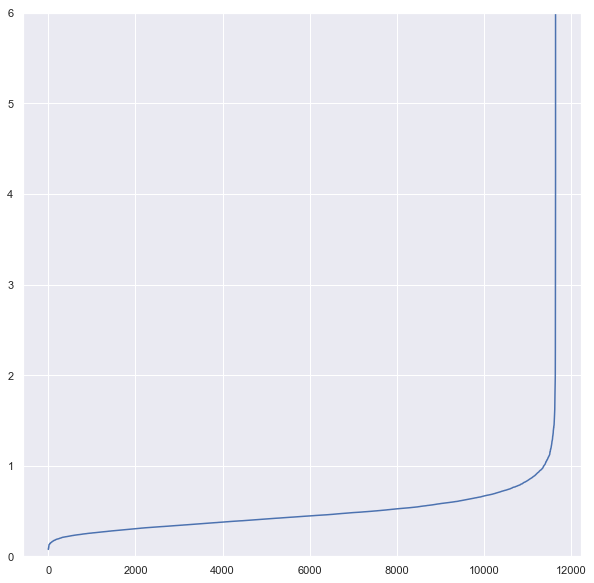

In [75]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(10,10))
plt.ylim(0, 6)
plt.plot(distances)
plt.show()

Using Nearest Neighbors, we can visualize the optimum value for the eps parameter. According to the visual, our optimum value is somewhere around 0.9.

In [76]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

#test a variety of min_samples values with the optimum eps

eps = [0.7, 0.8, 0.9, 1]
min_samples = [5, 10, 25, 50, 75, 100]

for ep in eps:
    for min_sample in min_samples:
        dbscan_cluster = DBSCAN(eps=ep, 
                                      min_samples=min_sample)
        clusters = dbscan_cluster.fit_predict(X_pca)
        
        print('DBSCAN with', ep, 'eps and', min_sample, 'min samples')
        print("The silhouette score of the DBSCAN solution: {}".format(metrics.silhouette_score(X_pca, clusters, metric='euclidean')))
        print('ARI Score of the DBSCAN solution: {}'.format(metrics.adjusted_rand_score(ydk, clusters)))
        print('----------------')

DBSCAN with 0.7 eps and 5 min samples
The silhouette score of the DBSCAN solution: -0.42212439420514036
ARI Score of the DBSCAN solution: 0.23022492963174515
----------------
DBSCAN with 0.7 eps and 10 min samples
The silhouette score of the DBSCAN solution: 0.12857446684605287
ARI Score of the DBSCAN solution: 0.3728840693544277
----------------
DBSCAN with 0.7 eps and 25 min samples
The silhouette score of the DBSCAN solution: -0.1584160203488279
ARI Score of the DBSCAN solution: 0.09595367405577966
----------------
DBSCAN with 0.7 eps and 50 min samples
The silhouette score of the DBSCAN solution: -0.15422761518919495
ARI Score of the DBSCAN solution: -0.07042358410089242
----------------
DBSCAN with 0.7 eps and 75 min samples
The silhouette score of the DBSCAN solution: -0.18977524759000763
ARI Score of the DBSCAN solution: -0.04961499175397645
----------------
DBSCAN with 0.7 eps and 100 min samples
The silhouette score of the DBSCAN solution: -0.26835833429670525
ARI Score of the

In [155]:
#test a variety of min_samples values with the optimum eps

eps = [0.7, 0.8, 0.9, 1]
min_samples = [5, 10, 25, 50, 75, 100]

for ep in eps:
    for min_sample in min_samples:
        dbscan_cluster = DBSCAN(eps=ep, 
                                      min_samples=min_sample)
        clusters = dbscan_cluster.fit_predict(umap_results)
        
        print('DBSCAN with', ep, 'eps and', min_sample, 'min samples')
        print("The silhouette score of the DBSCAN solution: {}".format(metrics.silhouette_score(umap_results, clusters, metric='euclidean')))
        print('ARI Score of the DBSCAN solution: {}'.format(metrics.adjusted_rand_score(ydk, clusters)))
        print('----------------')

DBSCAN with 0.7 eps and 5 min samples
The silhouette score of the DBSCAN solution: 0.7158516049385071
ARI Score of the DBSCAN solution: 0.5814758306301655
----------------
DBSCAN with 0.7 eps and 10 min samples
The silhouette score of the DBSCAN solution: 0.7158516049385071
ARI Score of the DBSCAN solution: 0.5814758306301655
----------------
DBSCAN with 0.7 eps and 25 min samples
The silhouette score of the DBSCAN solution: 0.7158516049385071
ARI Score of the DBSCAN solution: 0.5814758306301655
----------------
DBSCAN with 0.7 eps and 50 min samples
The silhouette score of the DBSCAN solution: 0.7158516049385071
ARI Score of the DBSCAN solution: 0.5814758306301655
----------------
DBSCAN with 0.7 eps and 75 min samples
The silhouette score of the DBSCAN solution: 0.7158516049385071
ARI Score of the DBSCAN solution: 0.5814758306301655
----------------
DBSCAN with 0.7 eps and 100 min samples
The silhouette score of the DBSCAN solution: 0.23173564672470093
ARI Score of the DBSCAN solutio

In [185]:
# Defining the DBScan clustering
db_cluster = DBSCAN(eps=0.9, min_samples=25)

# Fit model
db_cluster.fit(X_pca)
y_pred_db = db_cluster.fit_predict(X_pca)

In [186]:
# Defining the DBScan clustering
db_cluster = DBSCAN(eps=0.9, min_samples=25)

# Fit model
db_cluster.fit(umap_results)
y_pred_dbu = db_cluster.fit_predict(umap_results)

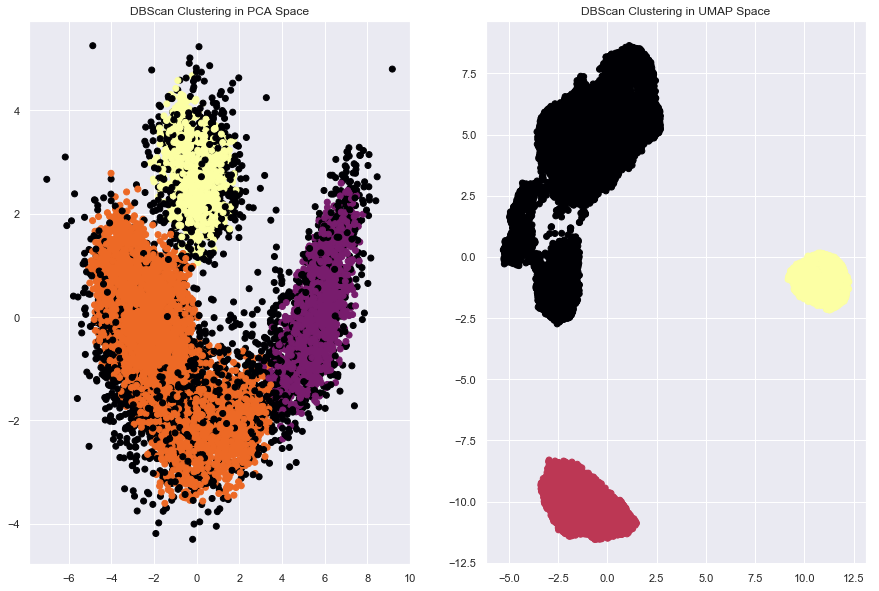

<Figure size 432x288 with 0 Axes>

In [187]:
# Plot the data
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_db, cmap='inferno')
plt.title('DBScan Clustering in PCA Space')

plt.subplot(1,2,2)
plt.scatter(umap_results[:, 0], umap_results[:, 1], c=y_pred_dbu, cmap='inferno')
plt.title('DBScan Clustering in UMAP Space')

plt.show()
plt.tight_layout()

In [80]:
print(pd.crosstab(y_pred_db, ydk))

pitch_type   CH   FC   FF    FT    SL
row_0                                
-1          465  334  529   560   618
 0            0    8    0     0  1776
 1            0  861  646  4882     0
 2          964    0    0     0     0


In [161]:
print(pd.crosstab(y_pred_db, ydk))

pitch_type    CH    FC    FF    FT    SL
row_0                                   
0              0  1153  1175  5439     1
1              0    43     0     0  2390
2           1429     7     0     3     3


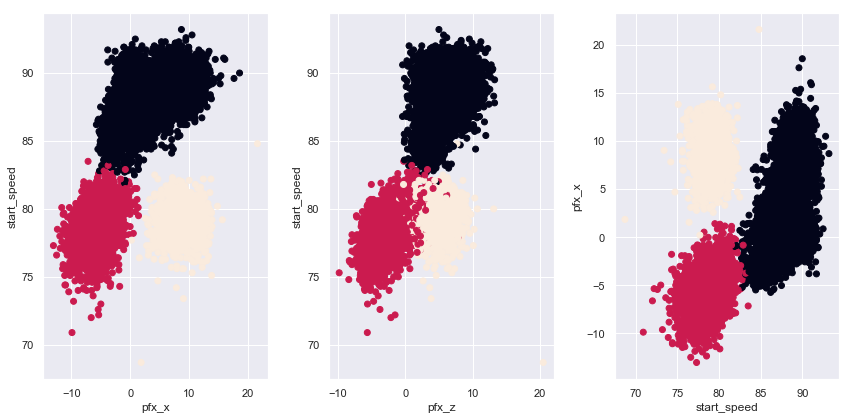

In [189]:
#project the clustering onto horizontal movement and start speed features

plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.scatter(keuchel['pfx_x'], keuchel['start_speed'], c=y_pred_dbu)
plt.xlabel('pfx_x')
plt.ylabel('start_speed')

plt.subplot(1,3,2)
plt.scatter(keuchel['pfx_z'], keuchel['start_speed'], c=y_pred_dbu)
plt.xlabel('pfx_z')
plt.ylabel('start_speed')

plt.subplot(1,3,3)
plt.scatter(keuchel['start_speed'], keuchel['pfx_x'], c=y_pred_dbu)
plt.xlabel('start_speed')
plt.ylabel('pfx_x')

plt.tight_layout()
plt.show()

The DBScan model clearly identified the high density areas. DBScan has chosen 3 clusters from the input. Going back to previous models, this makes sense if you cluster all fastballs into one category. Based on the information at hand in our EDA and the cross tabulation, the black cluster is his mix of fastballs, the red his slider and the tan is the changeup. 

The DBScan approach could definitely be useful if building a universal pitch clustering model as it finds the number of clusters based on density ie the number of clusters doesn't need to be assigned. We can see that it clusters all of Dallas' fastballs together and does an exceptional job separating his offspeed pitches. 

Could the noise be coming from poorly executed pitches? Even the best pitchers in the game throw bad pitches once in a while. 

### GMM Clustering

In [81]:
#pca components

from sklearn.mixture import GaussianMixture

covariance_types = ['full', 'tied', 'diag', 'spherical']
n_components = [2, 3, 4, 5]

for c in covariance_types:
    for n in n_components:
        gmm_cluster = GaussianMixture(n_components=n, random_state=123, 
                                     covariance_type=c)
        clusters = gmm_cluster.fit_predict(X_pca)
        print('GMM with', c, 'covariance type and', n, 'components')
        print("The silhouette score of the GMM solution: {}".format(metrics.silhouette_score(X_pca, clusters, metric='euclidean')))
        print('ARI Score of the GMM solution: {}'.format(metrics.adjusted_rand_score(ydk, clusters)))
        print('----------------')

GMM with full covariance type and 2 components
The silhouette score of the GMM solution: 0.42764236834946523
ARI Score of the GMM solution: 0.4573924803311089
----------------
GMM with full covariance type and 3 components
The silhouette score of the GMM solution: 0.308903650710397
ARI Score of the GMM solution: 0.7306000673125661
----------------
GMM with full covariance type and 4 components
The silhouette score of the GMM solution: 0.37159652893292466
ARI Score of the GMM solution: 0.8674978934829948
----------------
GMM with full covariance type and 5 components
The silhouette score of the GMM solution: 0.28711014540188606
ARI Score of the GMM solution: 0.6073148330393447
----------------
GMM with tied covariance type and 2 components
The silhouette score of the GMM solution: 0.48392112184210934
ARI Score of the GMM solution: 0.3304599776944296
----------------
GMM with tied covariance type and 3 components
The silhouette score of the GMM solution: 0.3570135196444846
ARI Score of t

In [162]:
#umap components

covariance_types = ['full', 'tied', 'diag', 'spherical']
n_components = [2, 3, 4, 5]

for c in covariance_types:
    for n in n_components:
        gmm_cluster = GaussianMixture(n_components=n, random_state=123, 
                                     covariance_type=c)
        clusters = gmm_cluster.fit_predict(umap_results)
        print('GMM with', c, 'covariance type and', n, 'components')
        print("The silhouette score of the GMM solution: {}".format(metrics.silhouette_score(umap_results, clusters, metric='euclidean')))
        print('ARI Score of the GMM solution: {}'.format(metrics.adjusted_rand_score(ydk, clusters)))
        print('----------------')

GMM with full covariance type and 2 components
The silhouette score of the GMM solution: 0.5930083990097046
ARI Score of the GMM solution: 0.499726014122703
----------------
GMM with full covariance type and 3 components
The silhouette score of the GMM solution: 0.7158516049385071
ARI Score of the GMM solution: 0.5814758306301655
----------------
GMM with full covariance type and 4 components
The silhouette score of the GMM solution: 0.655083179473877
ARI Score of the GMM solution: 0.8641199135959776
----------------
GMM with full covariance type and 5 components
The silhouette score of the GMM solution: 0.607301652431488
ARI Score of the GMM solution: 0.6185431577505892
----------------
GMM with tied covariance type and 2 components
The silhouette score of the GMM solution: 0.5930083990097046
ARI Score of the GMM solution: 0.499726014122703
----------------
GMM with tied covariance type and 3 components
The silhouette score of the GMM solution: 0.7158516049385071
ARI Score of the GMM 

In [196]:
#fit the model with pca components
gmm_cluster = GaussianMixture(n_components=5, random_state=123, covariance_type='full')
gmm_clusters = gmm_cluster.fit_predict(X_pca)

In [197]:
#fit the model with umap
gmm_cluster_umap = GaussianMixture(n_components=5, random_state=123, covariance_type='spherical')
gmm_clusters_umap = gmm_cluster_umap.fit_predict(umap_results)

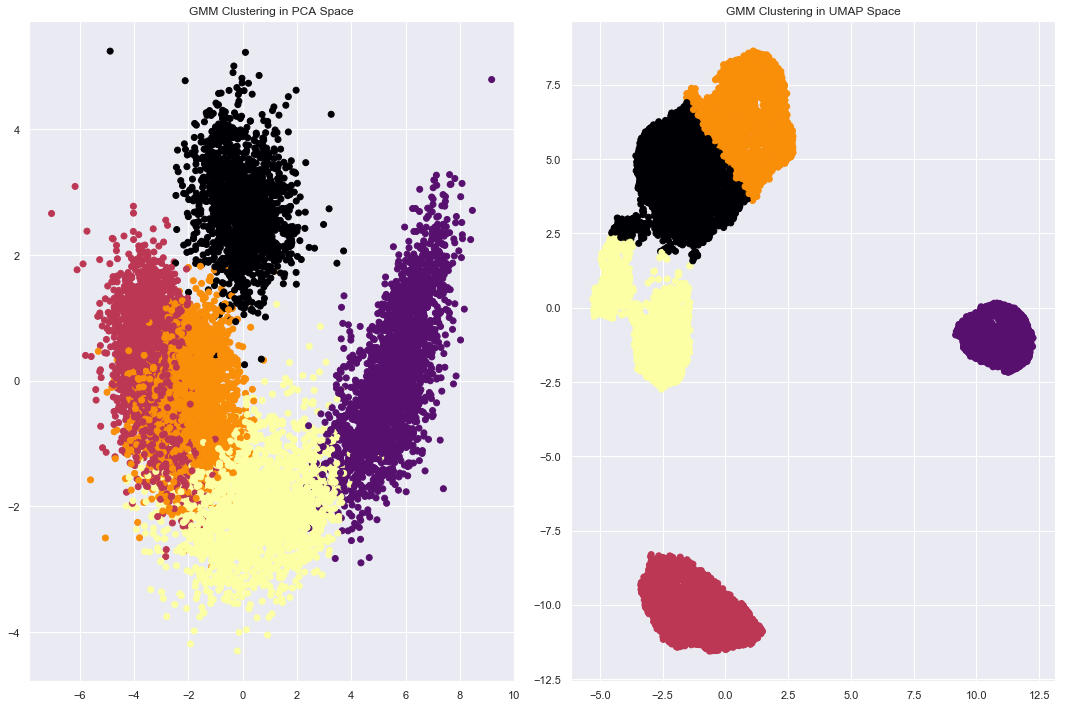

In [198]:
# Plot the data

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_clusters, cmap='inferno')
plt.title('GMM Clustering in PCA Space')

plt.subplot(1,2,2)
plt.scatter(umap_results[:, 0], umap_results[:, 1], c=gmm_clusters_umap, cmap='inferno')
plt.title('GMM Clustering in UMAP Space')

plt.tight_layout()
plt.show()

In [199]:
print(pd.crosstab(gmm_clusters, ydk))

pitch_type    CH    FC   FF    FT    SL
row_0                                  
0           1429     6    0     5     3
1              0    21    0     0  2355
2              0     1    7  2382     0
3              0    40  311  3003     0
4              0  1135  857    52    36


In [200]:
print(pd.crosstab(gmm_clusters_umap, ydk))

pitch_type    CH    FC   FF    FT    SL
row_0                                  
0              0    21  246  3007     0
1           1429     7    0     3     3
2              0    43    0     0  2390
3              0     0   25  2356     0
4              0  1132  904    76     1


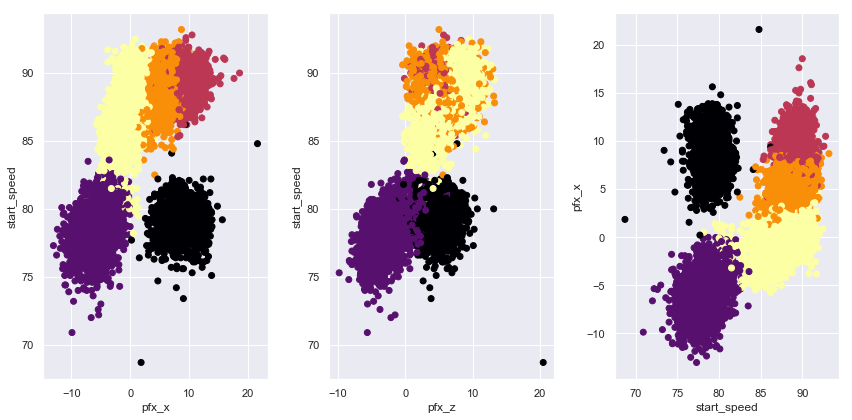

In [201]:
#project the clustering onto horizontal movement and start speed features

plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.scatter(keuchel['pfx_x'], keuchel['start_speed'], c=gmm_clusters, cmap='inferno')
plt.xlabel('pfx_x')
plt.ylabel('start_speed')

plt.subplot(1,3,2)
plt.scatter(keuchel['pfx_z'], keuchel['start_speed'], c=gmm_clusters, cmap='inferno')
plt.xlabel('pfx_z')
plt.ylabel('start_speed')

plt.subplot(1,3,3)
plt.scatter(keuchel['start_speed'], keuchel['pfx_x'], c=gmm_clusters, cmap='inferno')
plt.xlabel('start_speed')
plt.ylabel('pfx_x')

plt.tight_layout()
plt.show()

### Conclusions

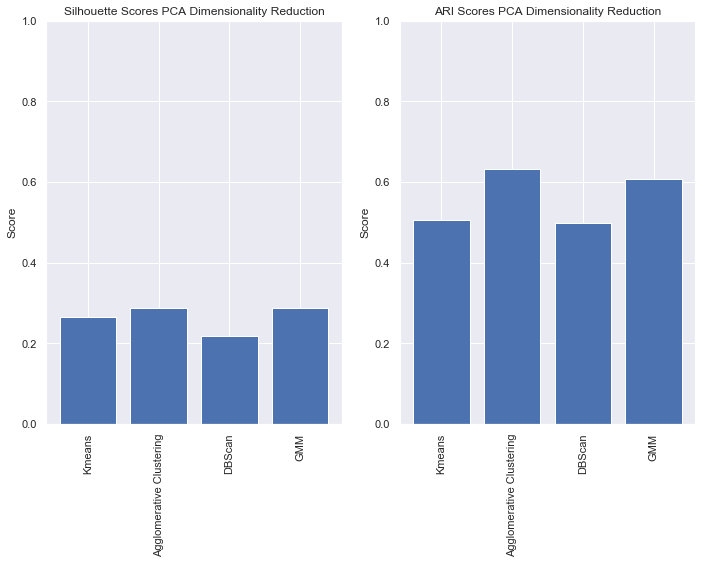

In [225]:
modelnames = ['Kmeans', 'Agglomerative Clustering', 'DBScan', 'GMM']

conclusion = pd.DataFrame({'Models': modelnames,
                           'Silhouettes': [metrics.silhouette_score(X_pca, predk, metric='euclidean'),
                                            metrics.silhouette_score(X_pca, y_pred_agg5, metric='euclidean'),
                                             metrics.silhouette_score(X_pca, y_pred_db, metric='euclidean'),
                                              metrics.silhouette_score(X_pca, gmm_clusters, metric='euclidean')],
                          'ARI': [metrics.adjusted_rand_score(ydk, predk),
                                  metrics.adjusted_rand_score(ydk, y_pred_agg5),
                                  metrics.adjusted_rand_score(ydk, y_pred_db),
                                  metrics.adjusted_rand_score(ydk, gmm_clusters)]})

plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.bar(conclusion.Models, conclusion.Silhouettes)
plt.title('Silhouette Scores PCA Dimensionality Reduction')
plt.xticks(rotation=90)
plt.ylim(0, 1)
plt.ylabel('Score')

plt.subplot(1,2,2)
plt.bar(conclusion.Models, conclusion.ARI)
plt.title('ARI Scores PCA Dimensionality Reduction')
plt.xticks(rotation=90)
plt.ylim(0, 1)
plt.ylabel('Score')


plt.tight_layout()
plt.show()

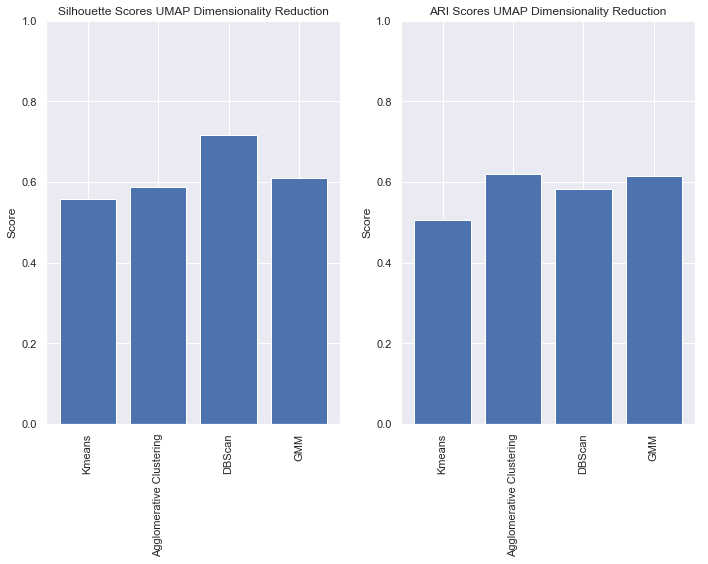

In [229]:
modelnames = ['Kmeans', 'Agglomerative Clustering', 'DBScan', 'GMM']

conclusionumap = pd.DataFrame({'models': modelnames,
                           'silhouettes': [metrics.silhouette_score(umap_results, predku, metric='euclidean'),
                                            metrics.silhouette_score(umap_results, y_pred_agg5umap, metric='euclidean'),
                                             metrics.silhouette_score(umap_results, y_pred_dbu, metric='euclidean'),
                                              metrics.silhouette_score(umap_results, gmm_clusters_umap, metric='euclidean')],
                          'ari': [metrics.adjusted_rand_score(ydk, predku),
                                  metrics.adjusted_rand_score(ydk, y_pred_agg5umap),
                                  metrics.adjusted_rand_score(ydk, y_pred_dbu),
                                  metrics.adjusted_rand_score(ydk, gmm_clusters_umap)]})

plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.bar(conclusionumap.models, conclusionumap.silhouettes)
plt.title('Silhouette Scores UMAP Dimensionality Reduction')
plt.xticks(rotation=90)
plt.ylim(0, 1)
plt.ylabel('Score')

plt.subplot(1,2,2)
plt.bar(conclusionumap.models, conclusionumap.ari)
plt.title('ARI Scores UMAP Dimensionality Reduction')
plt.xticks(rotation=90)
plt.ylim(0, 1)
plt.ylabel('Score')


plt.tight_layout()
plt.show()

Pitch clustering and classification is a difficult task, especially if one wants to build a universal model for all pitchers. The problem is, each pitcher is different and throws different pitches. This leads to the challenge of a finely tuned model for the data to fit into. Clustering an individual pitcher seems to be a manageable task but it takes the tuning of several parameters to get the best possible outcome. 

Based on the silhouette scores, the DBScan clustering approach performed the worst while the agglomerative clustering method worked best. This is also the case with the ARI scores. Note that all of these clustering models performed best with 4 clusters according to their scores, not 5. I chose to go with 5 clusters due to the fact that Dallas Keuchel throws five different pitches and I wanted to pinpoint the shortcomings of the different clustering methods. It is apparent that the clustering models have some trouble distinguishing fastballs with the given data but they all separated the off speed and breaking pitches well. 

The main disadvantage of Kmeans is the fact that the number of clusters must be fed into the model. It is, however, very simple to implement. Kmeans would not be suitable method for universal pitch clustering algorithm. 

The agglomerative clustering worked best when taking silhouette and ARI scores into account with PCA dimensionality reduction. Using the ward linkage gave the best results.

Using PCA dimensionality reduction, DBScan performed the worst of all the models, although, it showed the highest silhouette score when using umap dimensionality reduction. I feel DBScan could be very useful in building a universal pitch clustering model as it chooses the clusters based on density. 

GMM performed similarly to agglomerative clustering using both dimensionality reduction techniques. Although, the using different covariance types gave better scores - spherical for umap reduction and full for PCA. 

As a continuation of this project, I will attempt to build a universal pitch clustering classification model. The goal is to be able to feed any pitcher's data into the model and have it cluster their pitches correctly. With this approach, I think the DBScan model would be a good start as it can find outliers and determine the clusters based on density of the data points. In this initial project, the DBScan model succesfully clustered all the fastballs together and the off speed pitches as well. 